## **社群媒體分析 第九組**
- B094020012 李圯瀞
- B094020028 呂育真
- B094020040 王昱嵐

## **一、確立動機和分析目的**

我們選擇PPT上與生活層面相關的五個討論板（日旅、電影、科技工作、美食、股票），針對網友今年的討論內容進行文件分類與主題模型的分析，並以電影板為目標進行社會網路分析，觀察今年受到網友關注的電影角色或演員有哪些。

## **二、尋找適當的資料集**
*   資料來源：PTT（日旅、電影、科技工作、美食、股票）
*   去除關鍵字：
  *   日旅：徵人、問題、re、尋人、資訊、新聞、讓售、贈送
  *   電影：開箱、問片、新聞、請益、情報、片單、選片、live、re、討論
  *   科技工作 tech_job：誠徵、徵人、徵才、徵求、求才、re、新聞
  *   美食：轉讓、交換、情報、廣宣、日本、日式
  *   股票：re、心得、標的、情報、請益、閒聊、活動
*   時間：2023/01/01 ~ 2023/06/01


## **三、資料分析過程與結果解釋**
## **(1)文件分類**

In [ ]:
import pandas as pd
import re
import jieba

In [ ]:
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from matplotlib import font_manager
font_set = {f.name for f in font_manager.fontManager.ttflist}
plt.rcParams["font.sans-serif"] = ["Microsoft JhengHei"]

In [ ]:
ptt_raw = pd.read_csv("raw_data/data_merged.csv")
ptt_raw = ptt_raw.drop(columns=['system_id', 'e_ip', 'insertedDate', 'dataSource'])
ptt_raw.head(3)

,Unnamed: 0,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment
0,0,https://www.ptt.cc/bbs/Tech_Job/M.1675310634.A...,[討論]工研院資通所,2023-02-02 12:03:52,Rimowa,Tech_Job,轉貼\n\n醋院的薪水分享 (Dcard)\nhttps://www.dcard.tw/f/...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""getbacker"", ..."
1,1,https://www.ptt.cc/bbs/Tech_Job/M.1683208121.A...,[討論]該選擇設備還是機構？！,2023-05-04 21:48:39,sasaya7749,Tech_Job,嗨囉\n\n我就機械仔\n\n雖然修完iclab\n\n但出社會後依然面對現實\n\n最近拿...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""jim543000"", ..."
2,2,https://www.ptt.cc/bbs/Tech_Job/M.1674480733.A...,[問卷]員工敏捷關鍵事例研究問卷,2023-01-23 21:32:11,Obecne,Tech_Job,各位新年好，\n這裡是國立政治大學心理學研究所系工商心理學組的碩士班研究生，\n目前正在進行...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""hb177"", ""cmt..."


In [ ]:
# 移除網址格式
ptt_raw["artContent"] = ptt_raw.artContent.apply( lambda x: str(x) )
ptt_raw["artContent"] = ptt_raw.artContent.apply( lambda x: re.sub("(http|https)://.*", "", x) )
ptt_raw["artTitle"] = ptt_raw["artTitle"].apply( lambda x: re.sub("(http|https)://.*", "", x) )
# 只留下中文字
ptt_raw["artContent"] = ptt_raw.artContent.apply( lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x) )
ptt_raw["artTitle"] = ptt_raw["artTitle"].apply( lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x) )

ptt_raw.head(3)

,Unnamed: 0,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment
0,0,https://www.ptt.cc/bbs/Tech_Job/M.1675310634.A...,討論工研院資通所,2023-02-02 12:03:52,Rimowa,Tech_Job,轉貼醋院的薪水分享節錄部分科技業爆發前進去醋院第一年未滿一年本薪餐補年中年終調薪考績第二年滿...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""getbacker"", ..."
1,1,https://www.ptt.cc/bbs/Tech_Job/M.1683208121.A...,討論該選擇設備還是機構,2023-05-04 21:48:39,sasaya7749,Tech_Job,嗨囉我就機械仔雖然修完但出社會後依然面對現實最近拿到的都是半導體方面的設備機構該選哪個勒還是轉生,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""jim543000"", ..."
2,2,https://www.ptt.cc/bbs/Tech_Job/M.1674480733.A...,問卷員工敏捷關鍵事例研究問卷,2023-01-23 21:32:11,Obecne,Tech_Job,各位新年好這裡是國立政治大學心理學研究所系工商心理學組的碩士班研究生目前正在進行碩士論文的研...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""hb177"", ""cmt..."


In [ ]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

stopwords_manual = ["討論","請益","問卷"]
stopWords.extend(stopwords_manual)

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [ ]:
# 留下 content
ptt_class = ptt_raw.copy()
ptt_class["content"] = ptt_class["artTitle"] + ptt_class["artContent"]
ptt_class = ptt_class[["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結

ptt_class["words"] = ptt_class["content"].apply(getToken).map(" ".join)
ptt_class.head(3)

Building prefix dict from c:\Users\julie\OneDrive\桌面\大學TIME\111 大三下\社群媒體分析\Project\final_project\W11\dict\dict.txt.big ...
Dumping model to file cache C:\Users\julie\AppData\Local\Temp\jieba.u7f92ad803df6d1bff1bcdafd46635ac0.cache
Loading model cost 1.728 seconds.
Prefix dict has been built successfully.


,content,artUrl,artCatagory,words
0,討論工研院資通所轉貼醋院的薪水分享節錄部分科技業爆發前進去醋院第一年未滿一年本薪餐補年中年終...,https://www.ptt.cc/bbs/Tech_Job/M.1675310634.A...,Tech_Job,工研院 資通 轉貼 醋院 薪水 分享 節錄 部分 科技 爆發 前進 醋院 第一年 未滿 一年...
1,討論該選擇設備還是機構嗨囉我就機械仔雖然修完但出社會後依然面對現實最近拿到的都是半導體方面的...,https://www.ptt.cc/bbs/Tech_Job/M.1683208121.A...,Tech_Job,選擇 設備 機構 機械 修完 社會 依然 面對現實 最近 拿到 半導體 方面 設備 機構 該...
2,問卷員工敏捷關鍵事例研究問卷各位新年好這裡是國立政治大學心理學研究所系工商心理學組的碩士班研...,https://www.ptt.cc/bbs/Tech_Job/M.1674480733.A...,Tech_Job,員工 敏捷 關鍵 事例 研究 新年好 這裡 國立 政治 大學 心理學 研究所 工商 心理學 ...


In [ ]:
print(f"total posts: {len(ptt_class['artUrl'].unique())}")
print(f"category: \n{ptt_class['artCatagory'].value_counts()}")

total posts: 1500
category: 
artCatagory
Tech_Job        300
Food            300
Stock           300
Japan_Travel    300
movie           300
Name: count, dtype: int64


>可以看到我們的資料分布很平均，因此不需做刪減或增加的處理

>為了在分析時更方便，我們將資料的版別轉成中文

In [ ]:
class_df = ptt_class.copy()
class_df.loc[class_df['artCatagory'] == 'Tech_Job', 'artCatagory'] = '科技工作'
class_df.loc[class_df['artCatagory'] == 'Food', 'artCatagory'] = '美食'
class_df.loc[class_df['artCatagory'] == 'Stock', 'artCatagory'] = '股票'
class_df.loc[class_df['artCatagory'] == 'Japan_Travel', 'artCatagory'] = '日旅'
class_df.loc[class_df['artCatagory'] == 'movie', 'artCatagory'] = '電影'

print(f"category: \n{class_df['artCatagory'].value_counts()}")

category: 
artCatagory
科技工作    300
美食      300
股票      300
日旅      300
電影      300
Name: count, dtype: int64


In [ ]:
data = class_df
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

142     陽明 交大 課程 小弟 目前 學店 電機 碩班 學中 網路上 看到 陽明 交大 有開 半導體...
781     新聞 進入 植田 時代 經濟學家 估月超 寬鬆 原文 標題 進入 植田 時代 經濟學家 估月...
811     新聞 越南 寶元 鞋廠 下旬 起裁 人寶成 原文 標題 越南 寶元 鞋廠 下旬 起裁 人寶成...
1191    遊記 京都 水路 滿開 河津 完整 圖文 網誌 京都 河津 櫻淀 水路 滿開 紀錄 今年 首...
928     遊記 初訪 關西 好多 地方 造訪 日期 版友 女友 關西 行去 大阪 神戶 宇治 京都 這...
Name: words, dtype: object
142     科技工作
781       股票
811       股票
1191      日旅
928       日旅
Name: artCatagory, dtype: object


In [ ]:
# 看一下各個資料集切分的比例，應該要一致
print(
    f"raw data percentage :\n{data['artCatagory'].value_counts(normalize=True) * 100}"
)
print(f"\ntrain percentage :\n{y_train.value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{y_test.value_counts(normalize=True) * 100}")

raw data percentage :
artCatagory
科技工作    20.0
美食      20.0
股票      20.0
日旅      20.0
電影      20.0
Name: proportion, dtype: float64

train percentage :
artCatagory
科技工作    20.666667
日旅      20.476190
股票      20.000000
美食      19.523810
電影      19.333333
Name: proportion, dtype: float64

test percentage :
artCatagory
電影      21.555556
美食      21.111111
股票      20.000000
日旅      18.888889
科技工作    18.444444
Name: proportion, dtype: float64


In [ ]:
vectorizer = CountVectorizer(max_features=1000)
vectorizer.fit(X_train)
vec_train = vectorizer.transform(X_train)
vec_train.toarray()
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)

In [ ]:
clf = LogisticRegression()
clf.fit(vec_train, y_train)
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

In [ ]:
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          日旅       0.95      0.85      0.89        85
        科技工作       0.79      1.00      0.88        83
          美食       0.94      0.93      0.93        95
          股票       1.00      0.94      0.97        90
          電影       0.98      0.91      0.94        97

    accuracy                           0.92       450
   macro avg       0.93      0.93      0.92       450
weighted avg       0.93      0.92      0.93       450



>在使用LogisticRegression模型時的分類效果還不錯，F1-score都有達到0.9以上

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0, 0.5, '日旅'),
  Text(0, 1.5, '科技工作'),
  Text(0, 2.5, '美食'),
  Text(0, 3.5, '股票'),
  Text(0, 4.5, '電影')])

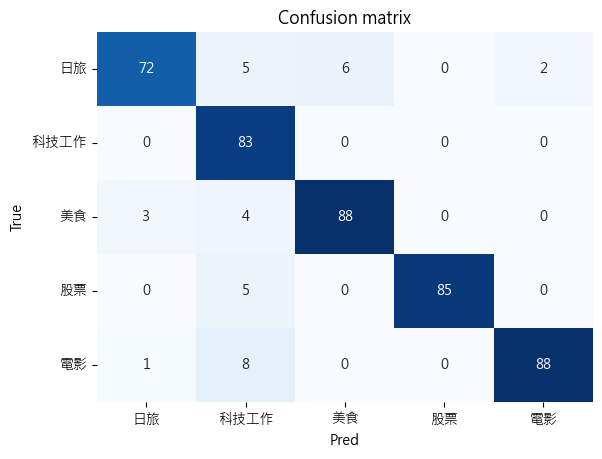

In [ ]:
classes = clf.classes_
cm = confusion_matrix(y_test, y_pred)

## Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)

##### 其中科技工作版的Precision偏低，而且Recall是最高的。我們推測可能是：  
<li>科技工作版比較會提到一些專有名詞或科技產業相關詞彙</li>
<li>若其他版的文章中有提到科技相關詞彙的話就有可能會被歸類為科技工作版</li> 
<br>* 最終導致科技工作版的Precision相比其他版較低。

In [ ]:
# one-hot encoding
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

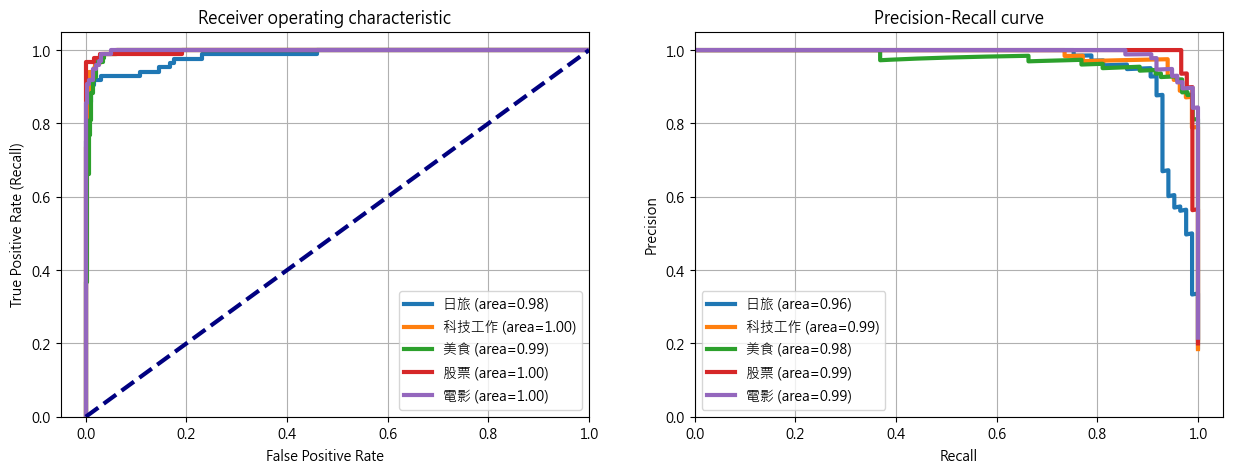

In [ ]:
# plot ROC curve and precision-recall curve
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = roc_curve(y_onehot_test[:, i], y_pred_proba[:, i])
    ax[0].plot(
        fpr, tpr, lw=3, label="{0} (area={1:0.2f})".format(classes[i], auc(fpr, tpr))
    )
ax[0].plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
ax[0].set(
    xlim=[-0.05, 1.0],
    ylim=[0.0, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate (Recall)",
    title="Receiver operating characteristic",
)
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = precision_recall_curve(
        y_onehot_test[:, i], y_pred_proba[:, i]
    )
    ax[1].plot(
        recall,
        precision,
        lw=3,
        label="{0} (area={1:0.2f})".format(classes[i], auc(recall, precision)),
    )
ax[1].set(
    xlim=[0.0, 1.05],
    ylim=[0.0, 1.05],
    xlabel="Recall",
    ylabel="Precision",
    title="Precision-Recall curve",
)
ax[1].legend(loc="best")
ax[1].grid(True)

>可以再次看出分類效果都還不錯

>那我們嘗試改用Tf-idf，試試看效果會不會更好

In [ ]:
vectorizer = TfidfVectorizer(max_features=1000)
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)

In [ ]:
clf.fit(vec_train, y_train)
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

# results
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          日旅       0.99      0.86      0.92        85
        科技工作       0.87      0.99      0.93        83
          美食       0.92      0.97      0.94        95
          股票       0.96      0.98      0.97        90
          電影       1.00      0.93      0.96        97

    accuracy                           0.94       450
   macro avg       0.95      0.94      0.94       450
weighted avg       0.95      0.94      0.94       450



>使用Tf-idf的分類效果有比使用count還要好一點，因此我們後面將改用Tf-idf

### CV

In [ ]:
clf = LogisticRegression()
vec_train = TfidfVectorizer(max_features=1000).fit_transform(X_train)

scores = cross_validate(clf, vec_train, y_train, cv=5, scoring=("f1_macro", "recall_macro", "precision_macro"), return_estimator=True)

y_pred = cross_val_predict(clf, vec_train, y_train, cv=5)

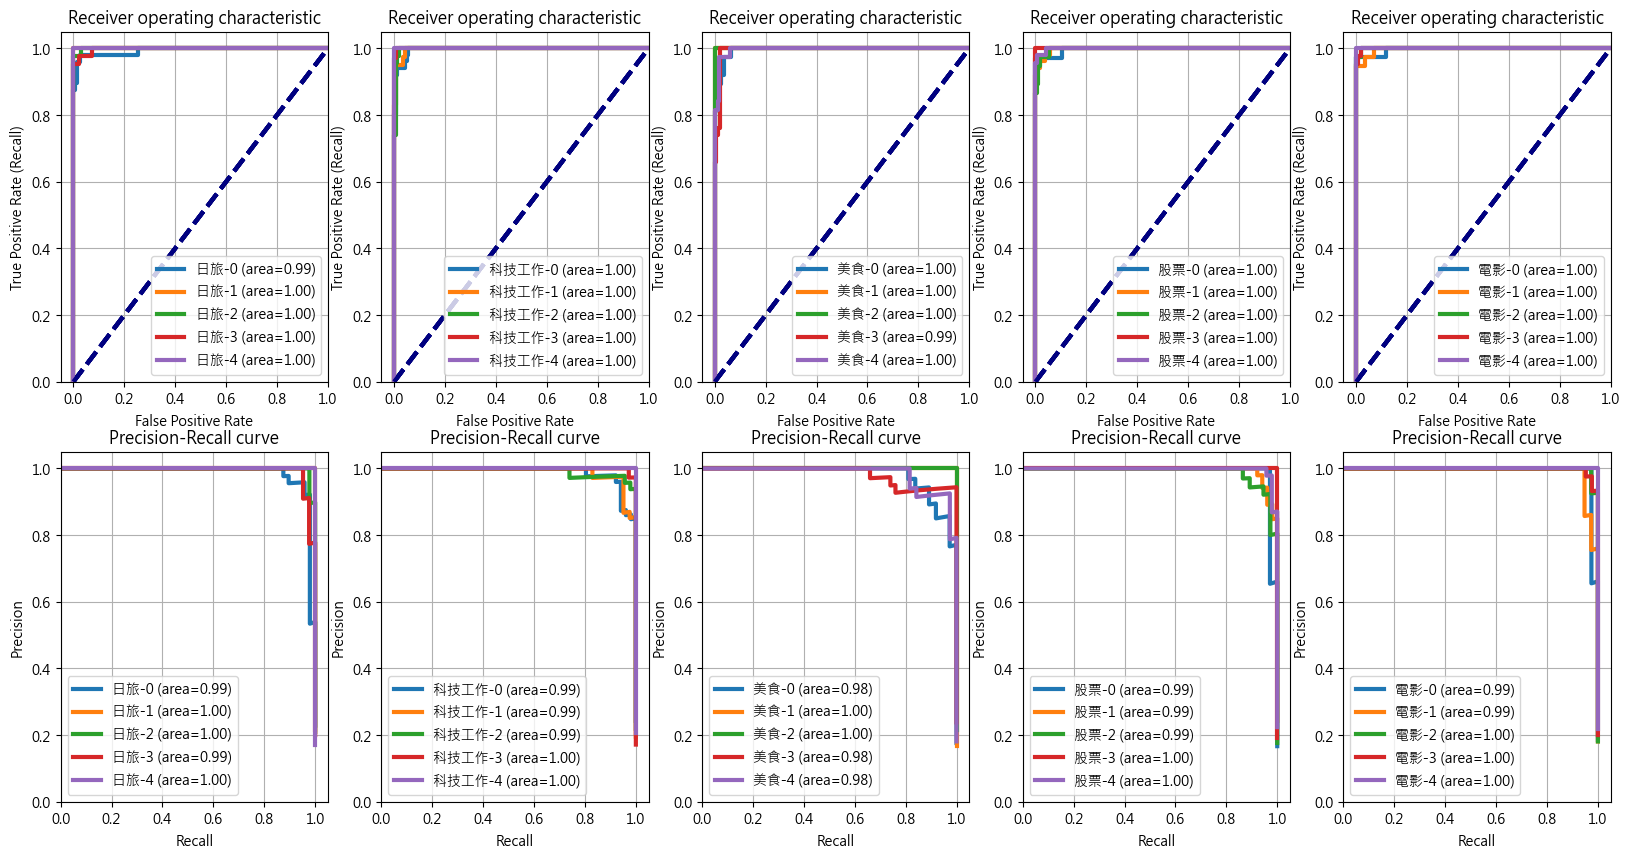

In [ ]:
## 將五個版別的 ROC curve 分別畫出來，並在同一張圖上比較不同 fold 的結果
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
kf = KFold(n_splits=5)
classes = scores['estimator'][0].classes_

for k, (train, test) in enumerate(kf.split(vec_train, y_train)):
    clf.fit(vec_train[train,:], y_train.iloc[train])
    y_pred = clf.predict(vec_train[test,:])    
    y_test = y_train.iloc[test]
    y_pred_proba = clf.predict_proba(vec_train[test,:])
    y_onehot_test = label_binarizer.transform(y_test)        
    

    ## Plot roc
    for i in range(len(classes)):
        fpr, tpr, thresholds = roc_curve(y_onehot_test[:, i], y_pred_proba[:, i])
        ax[0,i].plot(
            fpr,
            tpr,
            lw=3,
            label="{0}-{1} (area={2:0.2f})".format(classes[i], k, auc(fpr, tpr)),
        )
        ax[0,i].plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
        ax[0,i].set(
            xlim=[-0.05, 1.0],
            ylim=[0.0, 1.05],
            xlabel="False Positive Rate",
            ylabel="True Positive Rate (Recall)",
            title="Receiver operating characteristic",
        )
        ax[0,i].legend(loc="best")
        ax[0,i].grid(True)

    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = precision_recall_curve(
            y_onehot_test[:, i], y_pred_proba[:, i]
        )
        ax[1,i].plot(
            recall,
            precision,
            lw=3,
            label="{0}-{1} (area={2:0.2f})".format(classes[i], k,auc(recall, precision)),
        )
        ax[1,i].set(
            xlim=[0.0, 1.05],
            ylim=[0.0, 1.05],
            xlabel="Recall",
            ylabel="Precision",
            title="Precision-Recall curve",
        )
        ax[1,i].legend(loc="best")
        ax[1,i].grid(True)

plt.show()

美食版的效果相較之下較為遜色，推測可能原因：
<li>美食版的文章用詞比較不特定</li>
<li>比較多可能是原PO在抒發個人的心得</li>

In [ ]:
# 定義模型訓練組合
## pipeline: 資料處理 vectorizer + 分類器 clf
## 由於 cross-validation 會自動將資料分成 train/test，因此 input 只要給 X, y 即可

def train_cv(vectorizer, clf, X, y):

    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()
    
    ## get cv results
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, vec_X, y, cv=5, method="predict_proba")
    
    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    classes = cv_results['estimator'][0].classes_
    
    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title="Confusion matrix",
    )
    plt.yticks(rotation=0)


    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))

    kf = KFold(n_splits=5)
    
    for k, (train, test) in enumerate(kf.split(vec_X, y)):
        clf.fit(vec_X[train,:], y.iloc[train])
        y_pred = clf.predict(vec_X[test,:])    
        y_test = y.iloc[test]
        y_pred_proba = clf.predict_proba(vec_X[test,:])
        y_onehot_test = label_binarizer.transform(y_test)        
        
    
        ## Plot roc
        for i in range(len(classes)):
            fpr, tpr, thresholds = roc_curve(y_onehot_test[:, i], y_pred_proba[:, i])
            ax[0,i].plot(
                fpr,
                tpr,
                lw=3,
                label="{0}-{1} (area={2:0.2f})".format(classes[i], k, auc(fpr, tpr)),
            )
            ax[0,i].plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
            ax[0,i].set(
                xlim=[-0.05, 1.0],
                ylim=[0.0, 1.05],
                xlabel="False Positive Rate",
                ylabel="True Positive Rate (Recall)",
                title="Receiver operating characteristic",
            )
            ax[0,i].legend(loc="best")
            ax[0,i].grid(True)

        ## Plot precision-recall curve
        for i in range(len(classes)):
            precision, recall, thresholds = precision_recall_curve(
                y_onehot_test[:, i], y_pred_proba[:, i]
            )
            ax[1,i].plot(
                recall,
                precision,
                lw=3,
                label="{0}-{1} (area={2:0.2f})".format(classes[i], k,auc(recall, precision)),
            )
            ax[1,i].set(
                xlim=[0.0, 1.05],
                ylim=[0.0, 1.05],
                xlabel="Recall",
                ylabel="Precision",
                title="Precision-Recall curve",
            )
            ax[1,i].legend(loc="best")
            ax[1,i].grid(True)

    plt.show()

    clf.fit(vec_X, y)
    # return the model object
    return cls_report

              precision    recall  f1-score   support

          日旅       0.99      0.94      0.96       215
        科技工作       0.94      0.98      0.96       217
          美食       0.95      0.98      0.97       205
          股票       0.98      0.97      0.97       210
          電影       0.98      0.96      0.97       203

    accuracy                           0.97      1050
   macro avg       0.97      0.97      0.97      1050
weighted avg       0.97      0.97      0.97      1050



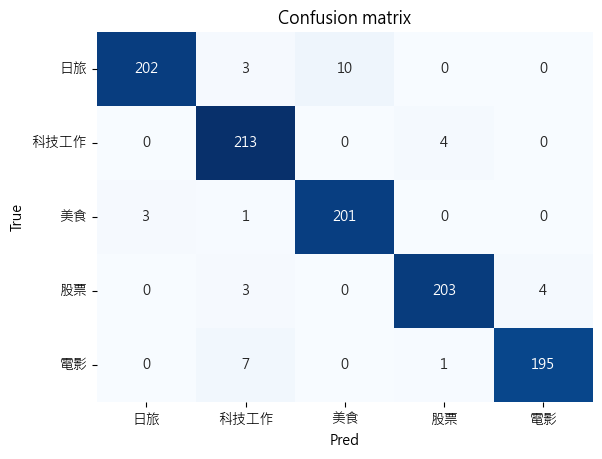

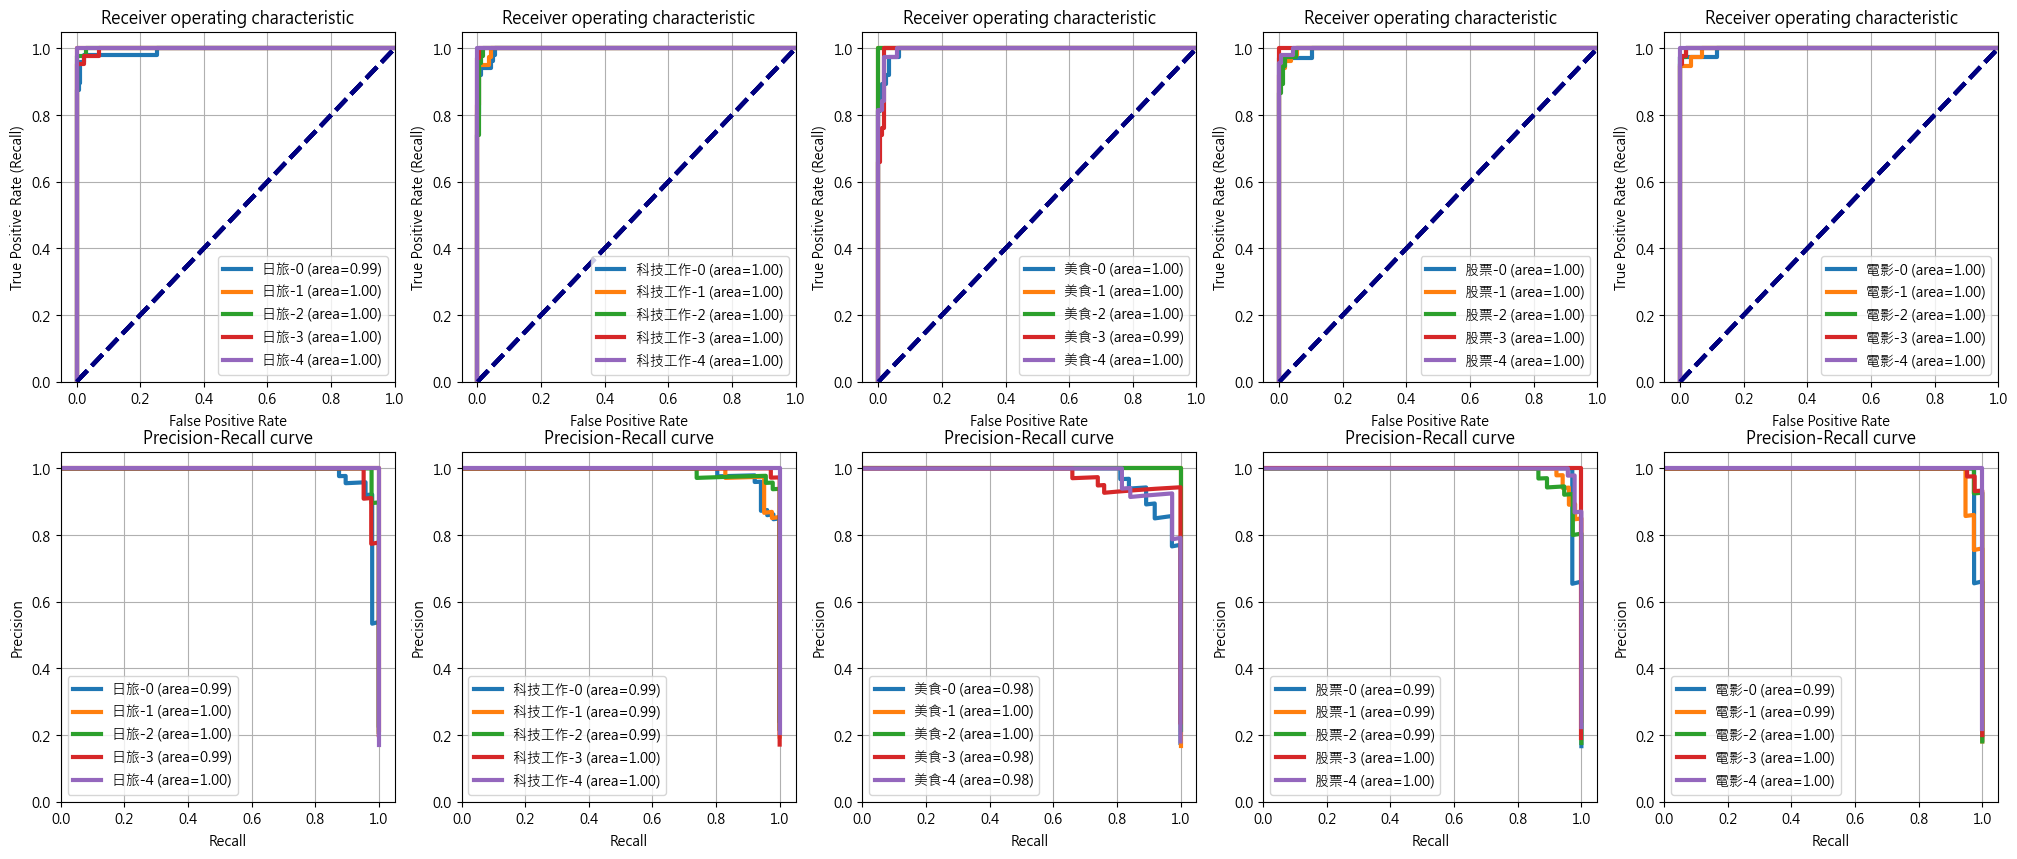

In [ ]:
vectorizer = TfidfVectorizer(max_features=1000)
clf = LogisticRegression()
result = train_cv(vectorizer, clf, X_train, y_train)

now training: clf_logistic
              precision    recall  f1-score   support

          日旅       0.99      0.94      0.96       215
        科技工作       0.94      0.98      0.96       217
          美食       0.95      0.98      0.97       205
          股票       0.98      0.97      0.97       210
          電影       0.98      0.96      0.97       203

    accuracy                           0.97      1050
   macro avg       0.97      0.97      0.97      1050
weighted avg       0.97      0.97      0.97      1050



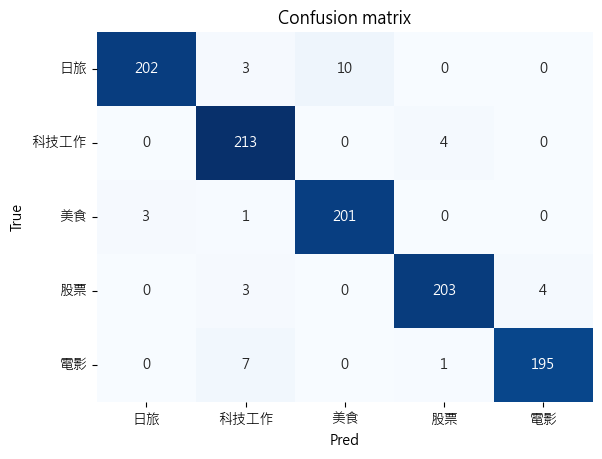

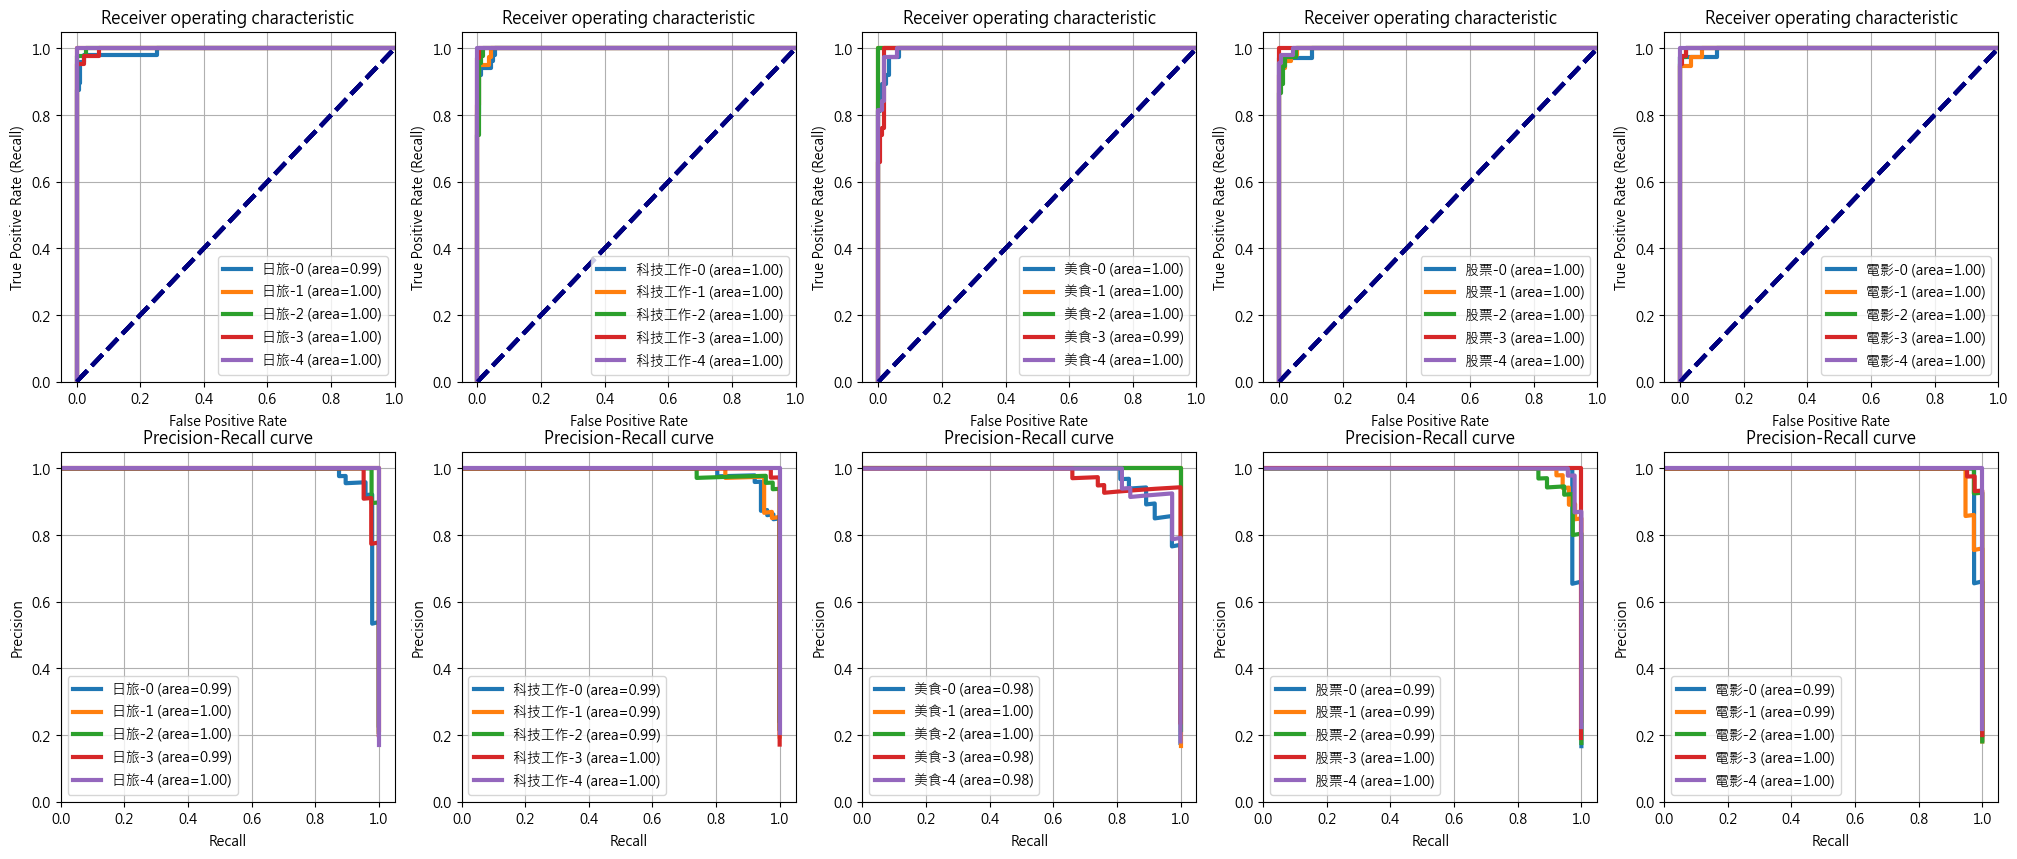

now training: clf_dtree
              precision    recall  f1-score   support

          日旅       0.94      0.89      0.91       215
        科技工作       0.82      0.94      0.87       217
          美食       0.95      0.92      0.94       205
          股票       0.94      0.92      0.93       210
          電影       0.94      0.91      0.92       203

    accuracy                           0.91      1050
   macro avg       0.92      0.91      0.91      1050
weighted avg       0.92      0.91      0.91      1050



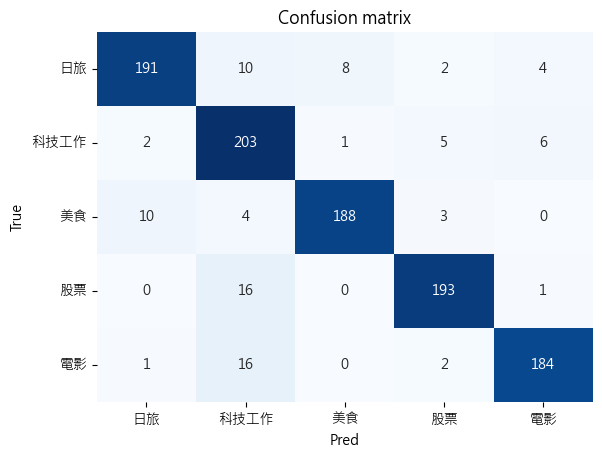

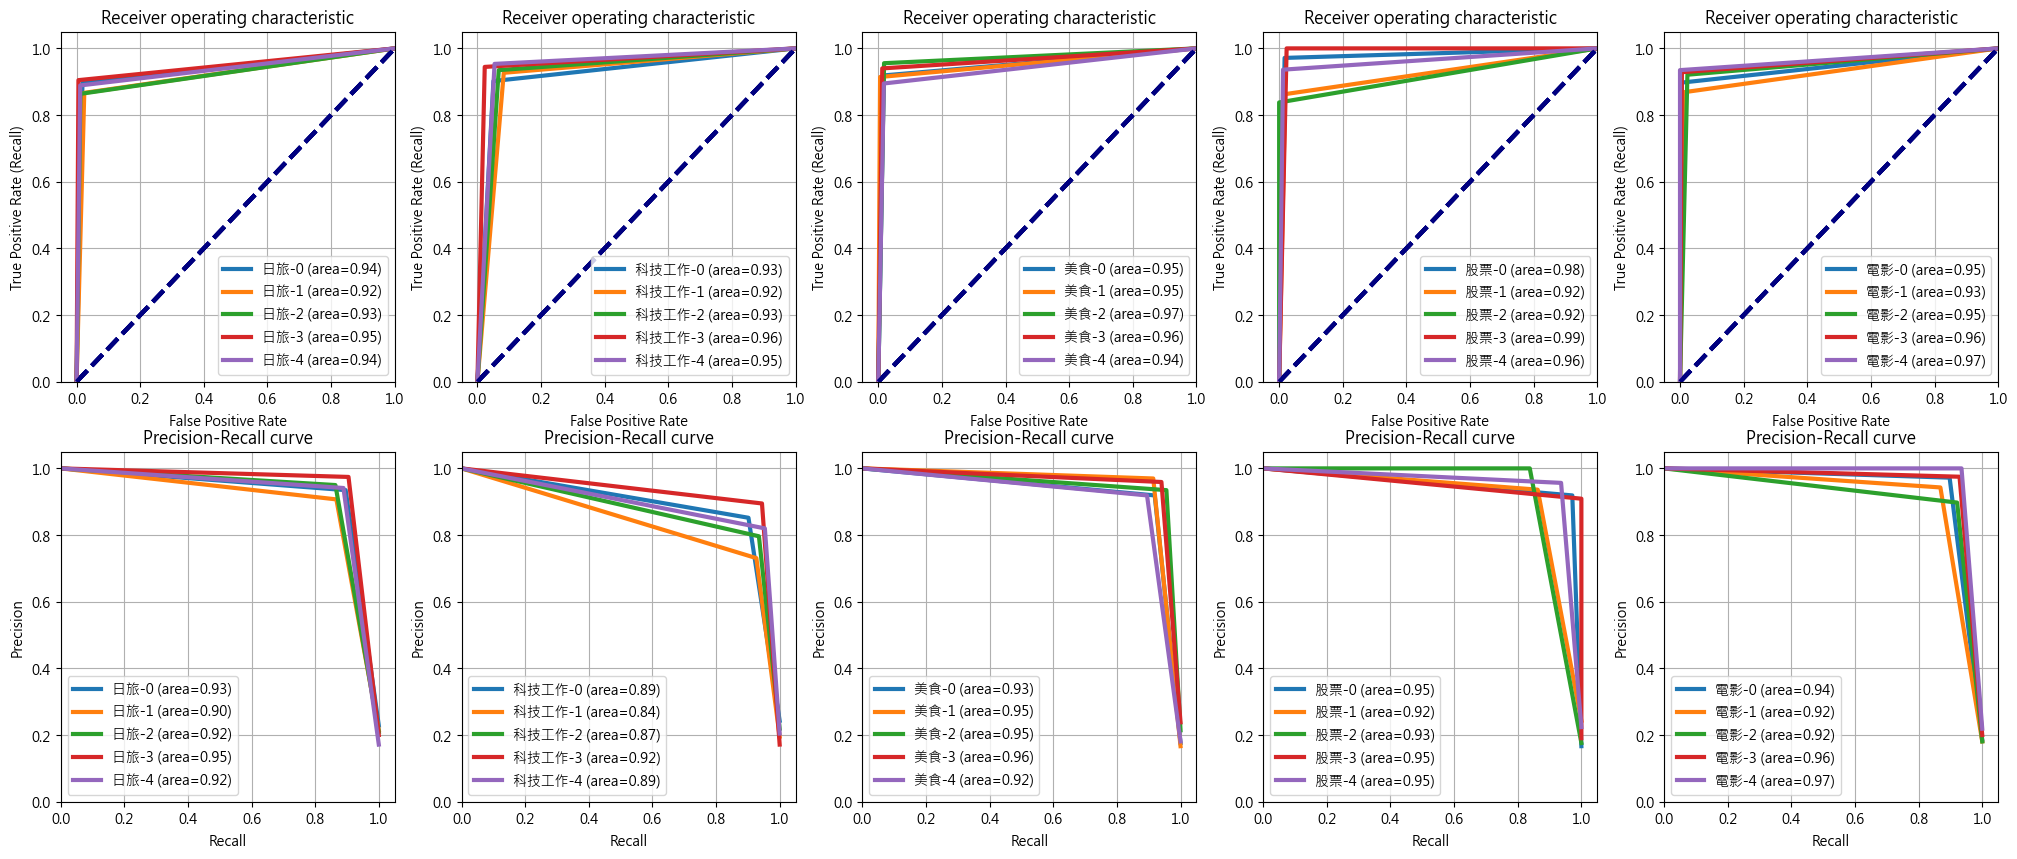

In [ ]:
# 準備訓練資料
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
# 定義模型訓練組合
model_set = dict()
model_set['clf_logistic'] = LogisticRegression()
model_set['clf_dtree'] = DecisionTreeClassifier()
# model_set['clf_rf'] = RandomForestClassifier()
# 定義 vectorizer
vectorizer = TfidfVectorizer(max_features=1000)
# 存結果
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)


In [ ]:
max = 0
best_model_name = ""
best_model_metric = "f1-score"

## choose max f1-score model from result_set
for k, v in result_set.items():
    if v['macro avg'][best_model_metric] > max:
        max = v['macro avg'][best_model_metric]
        best_model_name = k
print(f"best model: {best_model_name}")
pprint(result_set[best_model_name])

best model: clf_logistic
{'accuracy': 0.9657142857142857,
 'macro avg': {'f1-score': 0.9658302989940853,
               'precision': 0.9664319031736059,
               'recall': 0.9657694617094139,
               'support': 1050},
 'weighted avg': {'f1-score': 0.9657378842135043,
                  'precision': 0.9663107427439404,
                  'recall': 0.9657142857142857,
                  'support': 1050},
 '日旅': {'f1-score': 0.9619047619047618,
        'precision': 0.9853658536585366,
        'recall': 0.9395348837209302,
        'support': 215},
 '科技工作': {'f1-score': 0.9594594594594594,
          'precision': 0.9383259911894273,
          'recall': 0.9815668202764977,
          'support': 217},
 '美食': {'f1-score': 0.9663461538461539,
        'precision': 0.95260663507109,
        'recall': 0.9804878048780488,
        'support': 205},
 '股票': {'f1-score': 0.9712918660287081,
        'precision': 0.9759615384615384,
        'recall': 0.9666666666666667,
        'support': 210},
 '

>從我們上面做初的所有結果可以判斷出最佳分類器組合為 LogisticRegression 跟以 Tfidf 作為 vectorizer。 

In [ ]:
y_pred = model_set['clf_logistic'].predict(vectorizer.transform(X_test))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          日旅       0.99      0.86      0.92        85
        科技工作       0.87      0.99      0.93        83
          美食       0.92      0.97      0.94        95
          股票       0.96      0.98      0.97        90
          電影       1.00      0.93      0.96        97

    accuracy                           0.94       450
   macro avg       0.95      0.94      0.94       450
weighted avg       0.95      0.94      0.94       450



In [ ]:
model_set['clf_logistic'].predict(vectorizer.transform(["今天 大阪 環球影城 玩 還 去參觀了 京都 的 清水寺 真好玩"]))

array(['日旅'], dtype=object)

>嘗試放進自己打的句子去做預測，也能被準確的分類出來。

In [ ]:
model_set[best_model_name]

LogisticRegression()

In [ ]:
def plot_coef(logistic_reg_model, feature_names, top_n=10):
    # 選出某個類別的前10大影響力字詞
    log_odds = logistic_reg_model.coef_.T
    coef_df = pd.DataFrame(
        log_odds, 
        columns=logistic_reg_model.classes_, index=feature_names
    )
    for label in coef_df.columns:
        select_words = (
            coef_df[[label]]
            .sort_values(by=label, ascending=False)
            .iloc[np.r_[0:top_n, -top_n:0]]
        )
        word = select_words.index
        count = select_words[label]
        category_colors = np.where(
            select_words[label] >= 0, "darkseagreen", "rosybrown"
        )  # 設定顏色

        fig, ax = plt.subplots(figsize=(8, top_n*0.8))  # 設定畫布
        plt.rcParams["axes.unicode_minus"] = False

        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title(
            "Coeff increase/decrease odds ratio of 「" + label + "」 label the most",
            loc="left",
            size=16,
        )
        ax.set_ylabel("word", size=14)
        ax.set_xlabel("Word Frequency", size=14)

C:\Users\julie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


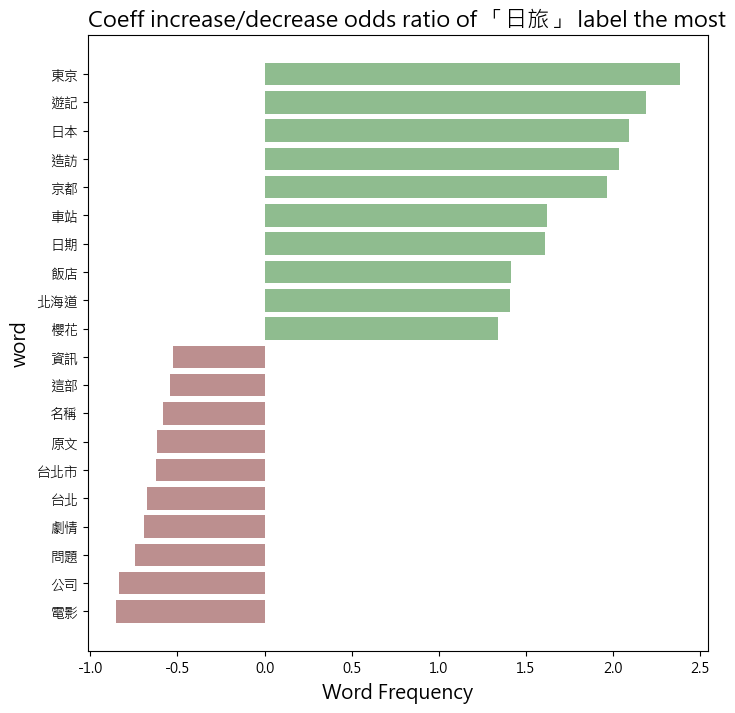

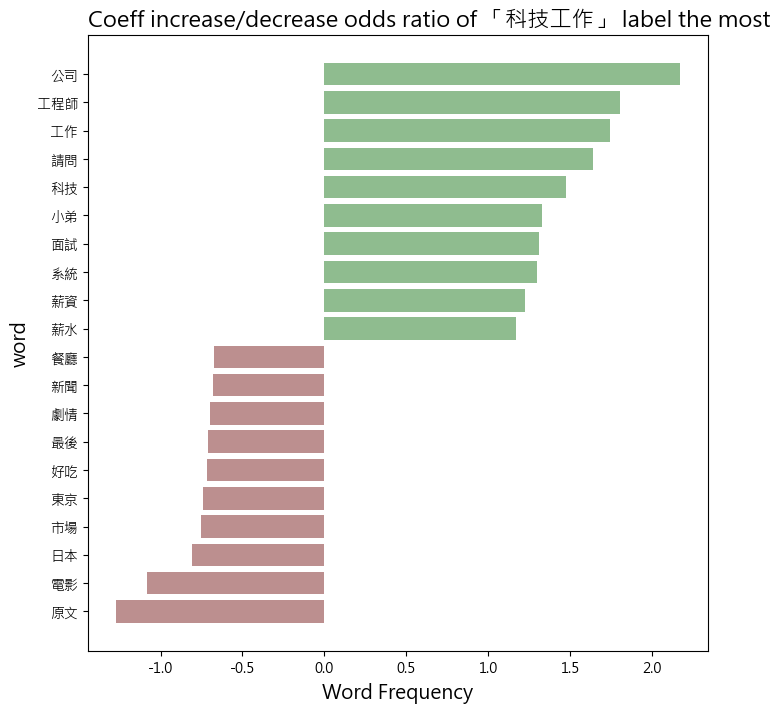

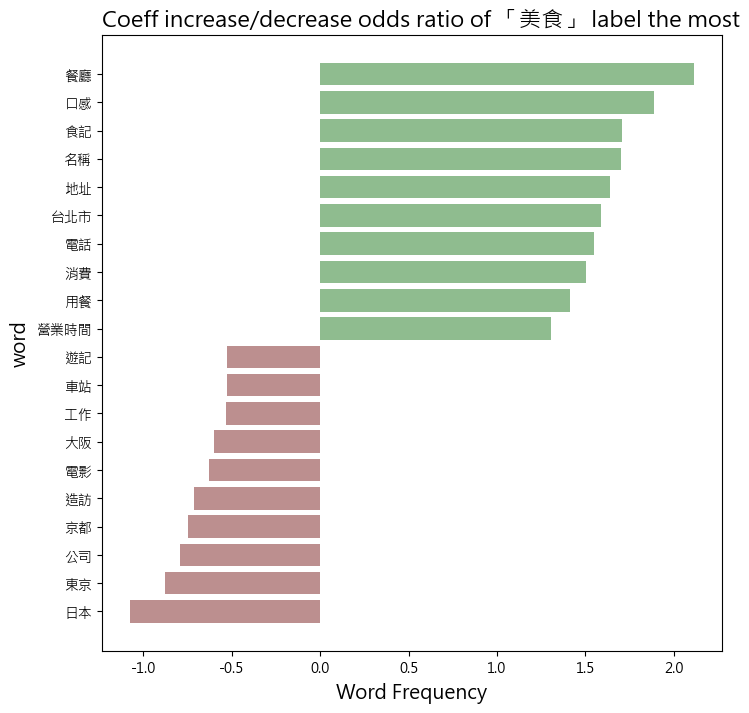

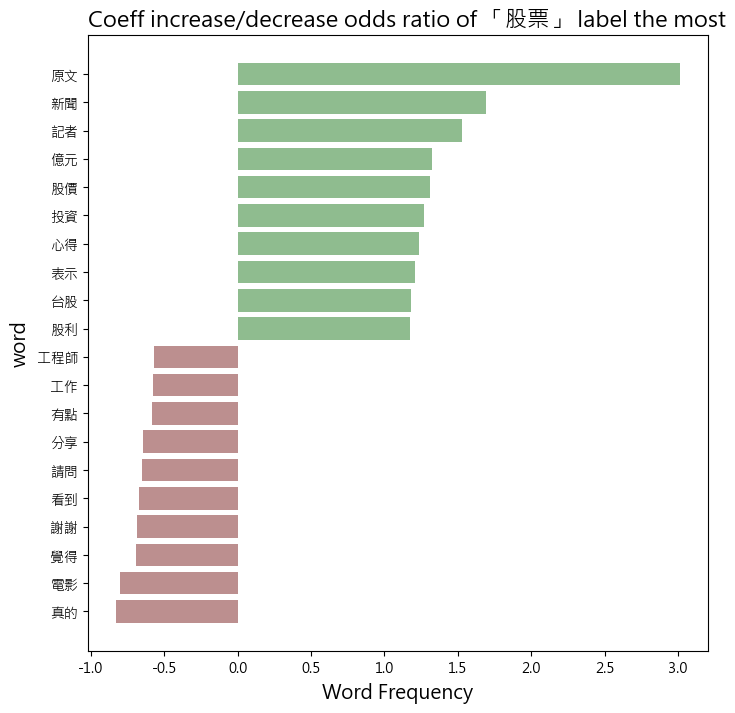

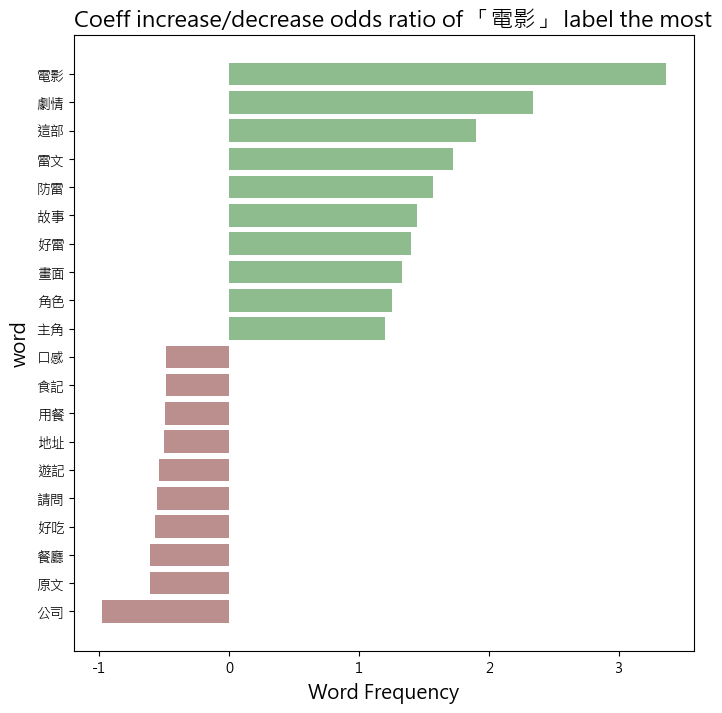

In [ ]:
plot_coef(logistic_reg_model=model_set[best_model_name], feature_names=vectorizer.get_feature_names(), top_n=10)

>可以看出就如同我們之前所猜測的為甚麼科技工作版的Recall會最高的原因，科技工作版的重點正向影響詞彙在其他版的文章中都比較少見一點。

### 套入 Dcard 資料來測試看看模型

In [ ]:
dcard = pd.read_csv("./raw_data/dcard.csv")
dcard = dcard.drop(columns=['system_id', 'post_id', 'artDate', 'school', 'department', 'nickname','posterID','gender','artComment','dataSource'])
dcard.dropna(inplace=True)

# 移除網址格式
dcard["artContent"].str.replace("(http|https)://.*", "", regex=True)
dcard["artTitle"].str.replace("(http|https)://.*", "", regex=True)
dcard["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
dcard["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)

dcard.rename(columns={'forumName': 'artCatagory'}, inplace=True)

# 留下 content
dcard["content"] = dcard["artTitle"] + dcard["artContent"]
dcard = dcard.loc[:,["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

dcard["words"] = dcard["content"].apply(getToken).map(" ".join)

dcard.head(3)

,content,artUrl,artCatagory,words
0,家人一直勸說從軍如題，最近我妹考完統測，我爸叫他報考軍校（空軍），說聽我姑姑的男朋友說很輕鬆...,https://www.dcard.tw/f/job/p/238880397,工作,家人 一直 勸說 從軍 最近 我妹 考完 統測 我爸 報考 軍校 空軍 姑姑 男朋友 輕鬆 ...
1,社群小編薪水？如標題，想詢問一下大家，飲料店的社群小編，工作內容：，1.經營IG、FB、Go...,https://www.dcard.tw/f/job/p/238957559,工作,社群 小編 薪水 標題 詢問 一下 飲料店 社群 小編 工作 內容 經營 IG FB Goo...
2,#問 緯創職缺［麥哲倫計畫］？想請問有人知道關於緯創這個計畫的資訊內容嗎？，因為網路上和官網...,https://www.dcard.tw/f/job/p/238949371,工作,緯創 職缺 麥哲倫 計畫 請問 有人 知道 緯創 計畫 資訊 內容 網路上 網上 沒什麼 相...


In [ ]:
dcard['artCatagory'].value_counts()

artCatagory
工作      100
美食      100
股票      100
旅遊      100
戲劇綜藝    100
Name: count, dtype: int64

In [ ]:
mapper = {"工作":"科技工作", "美食":"美食", "股票":"股票", "旅遊": "日旅", "戲劇綜藝":"電影"}
dcard['artCatagory'] = dcard['artCatagory'].map(mapper)

X = dcard['words']
y = dcard['artCatagory']
y_pred = model_set[best_model_name].predict(vectorizer.transform(X))
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

          日旅       0.89      0.83      0.86       100
        科技工作       0.51      0.96      0.67       100
          美食       0.91      0.62      0.74       100
          股票       0.90      0.43      0.58       100
          電影       0.92      0.96      0.94       100

    accuracy                           0.76       500
   macro avg       0.83      0.76      0.76       500
weighted avg       0.83      0.76      0.76       500



In [ ]:
dcard['pred'] = y_pred
dcard.loc[:,['words', 'artCatagory',"pred"]]

,words,artCatagory,pred
0,家人 一直 勸說 從軍 最近 我妹 考完 統測 我爸 報考 軍校 空軍 姑姑 男朋友 輕鬆 ...,科技工作,科技工作
1,社群 小編 薪水 標題 詢問 一下 飲料店 社群 小編 工作 內容 經營 IG FB Goo...,科技工作,科技工作
2,緯創 職缺 麥哲倫 計畫 請問 有人 知道 緯創 計畫 資訊 內容 網路上 網上 沒什麼 相...,科技工作,科技工作
3,最低工資 大學 畢業生 今天 發薪日 每個 看到 覺得 每天 準時 下班 固定 週休 六日 ...,科技工作,科技工作
4,台積電 面試 面都 結束 兩三天 前人 打電話 核薪 問我 30 可不可以 報到 入取 機率...,科技工作,科技工作
...,...,...,...
495,56 金鐘獎 入圍 統計 天橋 入圍 14 做工 婆婆 緊追 https imgur com...,電影,電影
496,分享 一閃 閃亮 星星 片段 假日 追完 之後 終於 知道 這部 二刷 電影 明年 上映 真...,電影,電影
497,韓劇 Voice 4Voice 第四季 終於 完結 QQ 首播 每個 禮拜 期待 更新 突然...,電影,電影
498,臺劇 基因 決定 我愛你 BL 九月底 開拍 更新 B10 林暉 首度 挑戰 BL 台灣 最...,電影,電影


In [ ]:
false_pred = dcard.query("artCatagory != pred").loc[:,['words', 'artCatagory',"pred"]]
false_pred

,words,artCatagory,pred
11,再生 奴隸 新生兒 創新 生育率 全球 最低 臺灣 生育率 警訊 登上 新聞 報導 可恥 老...,科技工作,股票
33,市調 飲料 口味 測試 18 35 男女 車馬費 500 1.18 35 男女 居住 台北市...,科技工作,美食
73,投資 詐騙 手法 宣稱 投資 標的 獲利 風險 以偽造 案例 影片 資料 製造 許多 投資 ...,科技工作,股票
95,大使 計畫 介紹 大使 計畫 成為 搶手 人才 趁現在 政府 推動 數位 青年 轉型 種子 ...,科技工作,股票
103,淡水 伴手禮 推薦 下週 淡水 知道 伴手 禮是 必買 好吃 徵求 推薦 一下 告訴 店名 ...,美食,日旅
...,...,...,...
395,小小 踩點 分享 去年 年底 搬來 開啟 探店 生活 真的 只能 樂趣 分享 一些 喜歡 名...,日旅,美食
413,推薦 心會 癢癢 純愛 劇如題 脫離 學生 時期 幾年 好懷念 以前 純純 戀愛 很久沒 看...,電影,科技工作
446,吳宗憲 退出 演藝圈 https fb watch 7GOgx Ouwf 轉自 星光 報導 ...,電影,科技工作
464,在家 追劇 世界 追完 遺物 整理 之前 一直 看成 遺產 模範 計程車 現在 法學院 17...,電影,科技工作


In [ ]:
false_pred.loc[false_pred['artCatagory']=='科技工作', :]

,words,artCatagory,pred
11,再生 奴隸 新生兒 創新 生育率 全球 最低 臺灣 生育率 警訊 登上 新聞 報導 可恥 老...,科技工作,股票
33,市調 飲料 口味 測試 18 35 男女 車馬費 500 1.18 35 男女 居住 台北市...,科技工作,美食
73,投資 詐騙 手法 宣稱 投資 標的 獲利 風險 以偽造 案例 影片 資料 製造 許多 投資 ...,科技工作,股票
95,大使 計畫 介紹 大使 計畫 成為 搶手 人才 趁現在 政府 推動 數位 青年 轉型 種子 ...,科技工作,股票


In [ ]:
false_pred.loc[false_pred['artCatagory']=='股票', :]

,words,artCatagory,pred
201,不久 將來 臺灣 真的 發生 戰爭 最近 台股 一直 我群 創套 好久 剩下 幾檔 綠油油 ...,股票,科技工作
204,股神 大賽 第一天 報酬率 700% 有沒有 參加 比賽 大神 一下 這是 玩法 https...,股票,科技工作
205,分享 2022 永豐 紀念品 開箱 https imgur com 2OcdbBp jpg ...,股票,科技工作
206,分享 奇夢家 台股 焦點 1909 榮成 2425 承啟 2356 英業達 3049 和鑫 ...,股票,科技工作
208,想問 教學 費用 請問 外面 老師上課 費用 上課 內容 真的 有用嗎 有人 分享 一下 最...,股票,科技工作
209,看見 朋友 股票 動態 心情 違規 請見 刪文 股票 理解 看到 朋友 結都 賠錢 只發 幾...,股票,科技工作
210,分享 一週 操作 記錄 5.7 這週 FED 放出 消息 偏空 立場 小弟 參考 大盤 明確...,股票,科技工作
212,分享 剛剛 踏空 最好 盈位 已經 出場 認知 現在 獲利 逆勢 操作 抄底 獲利 回事 思...,股票,科技工作
215,分享 王美股 22 科技股 繼續 下跌 是否 逃命 危險 機會 MOS NUE JETS X...,股票,科技工作
217,分享 好好笑 真的 存股 美股 再次 大跌 狂殺 900 多點 逼近 金融危機 慘況 漲漲跌...,股票,科技工作


>將模型拿去預測 Dcard 資料的類別後結果沒有很好。我們將預測錯誤的文章內容拿出來看一下發現很多是將「股票」預測成「科技工作」，我們從文章內容發現可能是在講股票的文章裡會提到一些科技公司的名字和一些專業用語。



## **(2)主題模型**





In [ ]:
import time 
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models

In [ ]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
# 圖形設定中文
import matplotlib.pyplot as plt
from matplotlib import font_manager

font_path = './SourceHanSansTW-Regular.otf'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus']=False #使負號能夠顯示
plt.rcParams['font.sans-serif'] = prop.get_name()

## 資料前處理

In [ ]:
udn = pd.read_csv("raw_data/data_merged.csv")  # 匯資料
udn.head(3)

,Unnamed: 0,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,0,113,https://www.ptt.cc/bbs/Tech_Job/M.1675310634.A...,[討論]工研院資通所,2023-02-02 12:03:52,Rimowa,Tech_Job,轉貼\n\n醋院的薪水分享 (Dcard)\nhttps://www.dcard.tw/f/...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""getbacker"", ...",180.217.248.23,2023-02-03 01:45:14,ptt
1,1,483,https://www.ptt.cc/bbs/Tech_Job/M.1683208121.A...,[討論]該選擇設備還是機構？！,2023-05-04 21:48:39,sasaya7749,Tech_Job,嗨囉\n\n我就機械仔\n\n雖然修完iclab\n\n但出社會後依然面對現實\n\n最近拿...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""jim543000"", ...",101.9.100.191,2023-05-05 02:14:48,ptt
2,2,90,https://www.ptt.cc/bbs/Tech_Job/M.1674480733.A...,[問卷]員工敏捷關鍵事例研究問卷,2023-01-23 21:32:11,Obecne,Tech_Job,各位新年好，\n這裡是國立政治大學心理學研究所系工商心理學組的碩士班研究生，\n目前正在進行...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""hb177"", ""cmt...",114.43.90.80,2023-01-24 01:42:08,ptt


In [ ]:
columns_to_drop = ['Unnamed: 0', 'artPoster', 'artComment', 'e_ip', 'insertedDate']
udn = udn.drop(columns=columns_to_drop)
udn.head(3)

,system_id,artUrl,artTitle,artDate,artCatagory,artContent,dataSource
0,113,https://www.ptt.cc/bbs/Tech_Job/M.1675310634.A...,[討論]工研院資通所,2023-02-02 12:03:52,Tech_Job,轉貼\n\n醋院的薪水分享 (Dcard)\nhttps://www.dcard.tw/f/...,ptt
1,483,https://www.ptt.cc/bbs/Tech_Job/M.1683208121.A...,[討論]該選擇設備還是機構？！,2023-05-04 21:48:39,Tech_Job,嗨囉\n\n我就機械仔\n\n雖然修完iclab\n\n但出社會後依然面對現實\n\n最近拿...,ptt
2,90,https://www.ptt.cc/bbs/Tech_Job/M.1674480733.A...,[問卷]員工敏捷關鍵事例研究問卷,2023-01-23 21:32:11,Tech_Job,各位新年好，\n這裡是國立政治大學心理學研究所系工商心理學組的碩士班研究生，\n目前正在進行...,ptt


In [ ]:
# 移除網址格式
# 只留下中文字
udn["artContent"] = udn["artContent"].str.replace("(http|https)://.*", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("(http|https)://.*", "", regex=True)
udn["artContent"] = udn["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn['content'] = udn['artContent']


udn = udn.loc[:,["content", "artUrl", "artCatagory", 'artDate']]  # 文章內容 文章連結
udn.head(3)

,content,artUrl,artCatagory,artDate
0,轉貼醋院的薪水分享節錄部分科技業爆發前進去醋院第一年未滿一年本薪餐補年中年終調薪考績第二年滿...,https://www.ptt.cc/bbs/Tech_Job/M.1675310634.A...,Tech_Job,2023-02-02 12:03:52
1,嗨囉我就機械仔雖然修完但出社會後依然面對現實最近拿到的都是半導體方面的設備機構該選哪個勒還是轉生,https://www.ptt.cc/bbs/Tech_Job/M.1683208121.A...,Tech_Job,2023-05-04 21:48:39
2,各位新年好這裡是國立政治大學心理學研究所系工商心理學組的碩士班研究生目前正在進行碩士論文的研...,https://www.ptt.cc/bbs/Tech_Job/M.1674480733.A...,Tech_Job,2023-01-23 21:32:11


In [ ]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt")

# 新增stopwords
jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stopwords.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    if isinstance(row, str):
        seg_list = jieba.cut(row, cut_all=False)
        seg_list = [w for w in seg_list if w not in stopWords and len(w) > 1]# 篩選掉停用字與字元數大於1的詞彙
        return seg_list
    else:
        return []

udn["words"] = udn["content"].apply(getToken)
udn.head()

Building prefix dict from c:\Users\user\OneDrive\桌面\社媒\final_project\dict\dict.txt ...
2023-06-08 12:05:21,893 : DEBUG : Building prefix dict from c:\Users\user\OneDrive\桌面\社媒\final_project\dict\dict.txt ...
Loading model from cache C:\Users\user\AppData\Local\Temp\jieba.udcb422dc9c6887ccfaab5cd48d45c503.cache
2023-06-08 12:05:21,893 : DEBUG : Loading model from cache C:\Users\user\AppData\Local\Temp\jieba.udcb422dc9c6887ccfaab5cd48d45c503.cache
Loading model cost 1.597 seconds.
2023-06-08 12:05:23,490 : DEBUG : Loading model cost 1.597 seconds.
Prefix dict has been built successfully.
2023-06-08 12:05:23,490 : DEBUG : Prefix dict has been built successfully.


,content,artUrl,artCatagory,artDate,words
0,轉貼醋院的薪水分享節錄部分科技業爆發前進去醋院第一年未滿一年本薪餐補年中年終調薪考績第二年滿...,https://www.ptt.cc/bbs/Tech_Job/M.1675310634.A...,Tech_Job,2023-02-02 12:03:52,"[轉貼, 醋院, 薪水, 分享, 節錄, 科技業, 爆發, 前進, 醋院, 第一年, 未滿,..."
1,嗨囉我就機械仔雖然修完但出社會後依然面對現實最近拿到的都是半導體方面的設備機構該選哪個勒還是轉生,https://www.ptt.cc/bbs/Tech_Job/M.1683208121.A...,Tech_Job,2023-05-04 21:48:39,"[機械, 修完, 但出, 社會, 依然, 面對, 現實, 最近, 拿到, 半導體, 方面, ..."
2,各位新年好這裡是國立政治大學心理學研究所系工商心理學組的碩士班研究生目前正在進行碩士論文的研...,https://www.ptt.cc/bbs/Tech_Job/M.1674480733.A...,Tech_Job,2023-01-23 21:32:11,"[新年, 國立, 政治, 大學, 心理學, 研究所, 工商, 心理學, 碩士班, 研究生, ..."
3,各位年薪三百的大大好想請問有沒有聽過衡陞科技的大大在站上或估狗爬文都找不太到資訊想問問裡面風...,https://www.ptt.cc/bbs/Tech_Job/M.1676493334.A...,Tech_Job,2023-02-16 04:35:32,"[年薪, 三百, 請問, 有沒有, 過衡, 科技, 站上, 估狗, 爬文, 不太到, 資訊,..."
4,最近來一位姑且稱長官專案成員中跟能力接近但不得長官心因為他之前開會直接嗆長官的話有大奶優勢加...,https://www.ptt.cc/bbs/Tech_Job/M.1682945779.A...,Tech_Job,2023-05-01 20:56:14,"[最近, 一位, 長官, 專案, 成員, 能力, 接近, 長官, 開會, 直接, 長官, 大..."


## Lexicon-based / 人工給定主題的主題模型

In [ ]:
udn['artCatagory'].unique()

array(['Tech_Job', 'Food', 'Stock', 'Japan_Travel', 'movie'], dtype=object)

In [ ]:
## 定義主題
Tech_Job_cnt = udn.loc[udn['artCatagory'] == 'Tech_Job',:]['words'].explode().value_counts().head(150)
pprint(" ".join(Tech_Job_cnt.index))

('公司 工作 目前 工程師 面試 小弟 薪資 內容 主管 問題 前輩 薪水 知道 謝謝 請問 加班 時間 未來 年薪 經驗 台灣 職位 最近 相關 分享 '
 '問卷 產品 工時 設計 部門 開發 機會 資訊 一下 分紅 地點 需要 研究 科技業 科技 看到 職缺 現在 感覺 希望 朋友 大學 今年 單位 請教 '
 '上班 發展 外商 管理 客戶 產業 獎金 機構 意見 現職 調薪 感謝 收到 有沒有 好像 建議 電子 一年 老闆 研發 詢問 轉職 選擇 專案 填答 '
 '畢業 聽說 以下 製程 去年 系統 出差 同事 網路 系統廠 主要 企業 新竹 缺點 拿到 背景 租屋 考慮 能力 設備 加班費 分鐘 員工 考量 優點 '
 '下班 願意 離職 社會 業務 績效 兩個 月薪 討論 不錯 風氣 通勤 資料 了解 直接 方面 人資 年終 英文 福利 台北 課程 之後 過去 狀況 '
 '最後 以前 裁員 年資 算是 辦公室 一直 左右 處理 發展性 進行 內部 豬屎 一點 計畫 軟體 小時 台積電 今天 技術 提供 壓力 情況 跳槽 '
 '事情')


In [ ]:
food_cnt = udn.loc[udn['artCatagory'] == 'Food',:]['words'].explode().value_counts().head(150)
pprint(" ".join(food_cnt.index))

('時間 餐廳 口感 地址 好吃 吃起來 營業 不錯 消費 電話 推薦 味道 用餐 口味 喜歡 名稱 店家 搭配 價位 餐點 圖文 選擇 平均 菜單 每人 '
 '裡面 甜點 感覺 看到 香氣 咖啡 朋友 特別 菜色 店內 價格 份量 有無 美味 料理 可否 刷卡 提供 套餐 網誌 一點 吃到 牛排 包廂 環境 '
 '好讀 美食 台灣 台北市 招牌 蛋糕 最後 這天 品項 海鮮 算是 雞肉 適合 使用 麵包 調味 豆腐 一下 小菜 一份 客人 知道 牛肉 附近 這道 '
 '沙拉 直接 飲料 湯頭 食材 火鍋 空間 醬汁 點餐 新鮮 服務 豬肉 一口 風味 座位 滿滿 公休 濃湯 位置 豐富 簡單 蔬菜 飲品 濃郁 雞腿 '
 '建議 酥脆 老闆 清爽 蛤蜊 方便 之外 軟嫩 便當 來到 滋味 發現 吃完 奶油 饅頭 完全 這間 看看 吃過 今天 檸檬 外帶 巧克力 冰淇淋 肉質 '
 '起司 部分 配料 分鐘 泰式 當天 點的 左右 配菜 想要 特色 需要 上面 位於 則是 一直 外皮 十分 排隊 炸雞 基隆市 傳統 原味 燉飯 早餐')


In [ ]:
stock_cnt = udn.loc[udn['artCatagory'] == 'Stock',:]['words'].explode().value_counts().head(150)
pprint(" ".join(stock_cnt.index))

('原文 公司 市場 今年 記者 時間 表示 去年 發布 美國 內容 億元 連結 心得 標題 評論 投資 署名 台積電 目前 股東 營收 銀行 台灣 中國 '
 '經濟 台股 半導體 股利 持續 預期 股價 指數 影響 全球 成長 指出 產業 獲利 晶片 現金 需求 產品 報導 股票 未來 億美 美元 政策 基金 '
 '認為 現在 科技 升息 相關 外資 主要 通膨 今天 董事長 包括 金融 第季 表現 企業 今日 大陸 政府 奈米 業者 新光金 董事 增加 價格 '
 '投資人 上市 景氣 發展 出現 下半年 生產 客戶 集團 超過 機會 營運 資本 每股 問題 預估 計畫 股市 庫存 蘋果 成為 上漲 維持 資金 '
 '股東會 國際 衰退 調整 成本 金管會 泰山 顯示 交易 進行 減少 盈餘 配息 公布 董事會 製程 預計 員工 技術 訂單 狀況 要求 過去 數據 '
 '台北 近期 聯準會 日本 合作 法人 風險 智慧 輝達 業務 面板 水準 疫情 因素 利率 宣布 美股 長榮 漲幅 提供 股息 消息 電子 虧損 先進 '
 '低於 中心 發放')


In [ ]:
japan_cnt = udn.loc[udn['artCatagory'] == 'Japan_Travel',:]['words'].explode().value_counts().head(150)
pprint(" ".join(japan_cnt.index))

('時間 飯店 日本 看到 車站 最後 神社 日期 造訪 好吃 一下 行程 東京 京都 拉麵 公園 分鐘 附近 機場 不錯 喜歡 選擇 排隊 北海道 推薦 '
 '感覺 直接 前往 店家 札幌 景點 晚上 特別 早餐 抵達 之後 搭配 發現 營業 巴士 小時 台灣 裡面 使用 地方 一點 房間 知道 櫻花 拍照 '
 '完全 大阪 住宿 提供 日幣 餐廳 博多 需要 抹茶 晚餐 味道 一直 口味 空間 行李 用餐 天氣 人員 可愛 官網 地址 不用 交通 溫泉 當天 '
 '口感 旅館 左右 網誌 體驗 旁邊 預約 建議 分享 來到 看看 今天 座位 方便 出發 纜車 好像 午餐 入口 簡單 仙台 遇到 入住 圖文 搭乘 '
 '烏龍麵 下午 店名 兩個 朋友 照片 入境 工作 福岡 適合 料理 決定 可惜 現場 人潮 本來 醬油 壽司 便宜 一間 東西 早上 介紹 菜單 函館 '
 '限定 價格 吃完 目前 牛肉 蛋糕 咖啡 店員 鰻魚 走到 吃到 飛機 日文 電話 這間 神宮 準備 中午 店內 中央 湯頭 算是 舒服 主要 服務')


In [ ]:
movie_cnt = udn.loc[udn['artCatagory'] == 'movie',:]['words'].explode().value_counts().head(150)
pprint(" ".join(movie_cnt.index))

('電影 最後 劇情 角色 知道 這部 看到 主角 故事 喜歡 雷文 觀眾 宮城 感覺 防雷 畫面 看完 之後 完全 作品 導演 出現 世界 真嗣 一直 '
 '時間 資訊 動畫 漫畫 一部 現在 主文 分隔線 一下 這種 鈴芽 想要 直接 部分 蟻人 發現 地方 變成 一點 問題 遊戲 可惜 根本 看過 不錯 '
 '日本 明日香 特別 實在 尤其 表現 無法 回憶 人類 好像 後面 本片 櫻木 比賽 新海 每個 希望 重要 好看 裡面 成為 家庭 認為 兩個 關係 '
 '家人 系列 節奏 人物 漫威 三井 電影院 感動 上映 期待 結局 過去 兩人 整個 算是 選擇 反派 設定 場景 需要 內容 一次 哥哥 呈現 那種 '
 '名字 情感 電影版 高手 過程 媽媽 劇場版 整部 太多 灌籃 有趣 演員 台灣 經典 這一 預告 星際 理解 事情 本來 值得 橋段 那段 母親 真實 '
 '前面 面對 音樂 細節 觀影 父親 印象 號機 人生 機會 女兒 心得 情緒 朋友 宇宙 基哥 量子 生活 推薦 以下 終於 更多 可愛 突然 赤木')


### 處理停用字

In [ ]:
stopWords = []

with open("./dict/stopwords.txt", "r", encoding="utf-8") as file:
    stopWords = [line.strip() for line in file.readlines()]

Tech_Job_cnt_words = [word for word in list(Tech_Job_cnt.index) if word not in stopWords]
food_cnt_words = [word for word in list(food_cnt.index) if word not in stopWords]
stock_cnt_words = [word for word in list(stock_cnt.index) if word not in stopWords]
japan_cnt_words = [word for word in list(japan_cnt.index) if word not in stopWords]
movie_cnt_words = [word for word in list(movie_cnt.index) if word not in stopWords]

In [ ]:
custom_topic_word = {
    "Tech_Job": Tech_Job_cnt_words,
    "Food": food_cnt_words,
    "Stock": stock_cnt_words,
    "Japan_Travel":  japan_cnt_words,
    "movie": movie_cnt_words,
}


In [ ]:
custom_topic_word = {
    "Tech_Job": [
        '公司', '工作', '工程師', '面試', '薪資', '主管', '前輩', '薪水', '加班', '年薪', '職位', '工時', 
        '部門', '科技業', '科技', '職缺', '大學', '單位', '上班', '發展', '外商', '管理', '客戶', '產業',
        '獎金', '現職', '調薪', '電子', '老闆', '轉職', '製程', '系統', '出差', '同事', '系統廠', '企業',
        '新竹', '背景', '加班費', '員工', '下班', '離職', '績效', '月薪', '通勤', '人資', '年終', '福利',
        '裁員', '年資', '辦公室', '發展性', '軟體', '台積電', '技術', '跳槽', 'GG', '專案', '開會', '長官'
    ],
    "Food": [
        '餐廳', '口感', '好吃', '吃起來', '營業', '消費', '味道', '用餐', '口味', '店家', '搭配', '價位', '餐點', 
        '菜單', '甜點', '香氣', '咖啡', '菜色', '店內', '價格', '份量', '美味', '料理', '刷卡', '套餐', '吃到飽', 
        '牛排', '包廂', '環境', '美食', '招牌', '蛋糕', '品項', '海鮮', '雞肉', '麵包', '調味', '豆腐', '小菜', '客人', 
        '沙拉', '飲料', '湯頭', '食材', '火鍋', '空間', '醬汁', '點餐', '新鮮', '服務', '豬肉', '風味', '座位', '公休', 
        '濃湯', '豐富', '蔬菜', '飲品', '濃郁', '雞腿', '酥脆', '老闆', '清爽', '蛤蜊', '軟嫩', '便當', '滋味', '吃完', 
        '奶油', '饅頭', '吃過', '檸檬', '外帶', '巧克力', '冰淇淋', '肉質', '起司', '配料', '泰式', '配菜', '特色', '外皮', 
        '排隊', '炸雞', '傳統', '原味', '燉飯', '早餐',
    ],
    "Stock": [
        '市場', '發布', '美國', '億元', '投資', '台積電', '股東', '營收', '銀行', '台灣', '中國', '經濟', '台股', '半導體', 
        '股利', '持續', '預期', '股價', '指數', '影響', '全球', '成長', '產業', '獲利', '晶片', '現金', '股票', '億美', '美元', 
        '政策', '基金', '升息', '外資', '通膨 ', '董事長', '金融', '第季', '表現', '企業', '大陸', '政府', '奈米', '業者', '新光金', 
        '董事', '增加', '價格', '投資人', '上市', '景氣', '發展', '下半年', '生產', '營運', '資本', '每股', '預估', '股市', '庫存', 
        '蘋果', '上漲', '資金', '股東會', '國際', '衰退', '調整', '成本', '金管會', '泰山', '交易', '盈餘', '配息', '公布', '董事會', 
        '製程', '數據', '聯準會', '法人', '風險', '輝達', '業務', '利率', '美股', '長榮', '漲幅', '股息', '虧損',
    ],
    "Japan_Travel": [
        '飯店', '日本', '車站', '神社', '造訪', '行程', '東京', '京都', '拉麵', '機場', '排隊', '北海道', '推薦', '札幌', '景點',
        '抵達', '巴士', '台灣', '櫻花', '大阪', '住宿', '日幣', '博多', '抹茶', '行李', '溫泉', '旅館', '體驗', '預約', '纜車', 
        '仙台', '入住', '烏龍麵', '入境', '福岡', '醬油', '壽司', '函館', '牛肉', '和牛', '鰻魚', '飛機', '日文', '神宮', '旅行', 
        '燒肉', '富士山', '遊客', '電車', '球場', '富山', '日式', '海鮮', '牛舌', '叉燒', '名古屋', '旅伴', '吃到飽', '醬汁', '熊本', 
        '冰淇淋', '羽田', '新幹線', '定食',
    ],
    "movie": [
        '電影', '劇情', '角色', '這部', '主角', '故事', '雷文', '觀眾', '防雷', '畫面', '作品', '導演', '動畫', '漫畫', '一部',
        '主文', '鈴芽', '蟻人', '日本', '明日香', '本片', '櫻木', '比賽', '新海', '新海城', '好看', '系列', '節奏', '人物', '漫威',
        'DC', '三井', '電影院', '感動', '上映', '期待', '結局', '反派', '設定', '場景', '內容', '呈現', '名字', '情感', '電影版', 
        '高手', '劇場版', '整部', '灌籃', '有趣', '演員', '經典', '預告', '星際', '橋段', '那段', '真實', '音樂', '細節', '觀影', 
        '印象', '心得', '推薦', '特效', '風格', '台詞', '這片', '開頭', '背景', '動作', '完整', '靈魂', '異攻隊', '元素', '場面', 
        '原作', '票房', '結尾', '觀賞', '片段', '影片', '美國', '流川', '冒險', '井上', '事件', '兄弟', '改編', '戲院', '感受到', 
        '關鍵', '笑點', '想像', '感受', '評價', '類似', '製作', '進場', '對話', '英雄', '熱血', '劇本', '後續', '彩蛋'
    ],
}


In [ ]:
vocabularies = np.unique(reduce(lambda x, y: x + y, custom_topic_word.values()))

In [ ]:
vocabularies

array(['DC', 'GG', '一部', '三井', '上市', '上映', '上漲', '上班', '下半年', '下班', '中國',
       '主文', '主管', '主角', '事件', '井上', '交易', '京都', '人物', '人資', '仙台', '份量',
       '企業', '住宿', '作品', '便當', '傳統', '價位', '價格', '億元', '億美', '元素', '兄弟',
       '入住', '入境', '內容', '全球', '公休', '公司', '公布', '冒險', '冰淇淋', '出差', '函館',
       '利率', '刷卡', '前輩', '劇場版', '劇情', '劇本', '加班', '加班費', '動作', '動畫', '包廂',
       '北海道', '升息', '半導體', '博多', '印象', '原作', '原味', '叉燒', '反派', '口味', '口感',
       '台灣', '台積電', '台股', '台詞', '吃到飽', '吃完', '吃起來', '吃過', '同事', '名古屋',
       '名字', '呈現', '味道', '和牛', '咖啡', '品項', '員工', '單位', '國際', '基金', '場景',
       '場面', '增加', '壽司', '外商', '外帶', '外皮', '外資', '大學', '大阪', '大陸', '奈米',
       '套餐', '奶油', '好吃', '好看', '完整', '定食', '客人', '客戶', '富士山', '富山', '專案',
       '對話', '導演', '小菜', '工作', '工時', '工程師', '巧克力', '巴士', '市場', '年終', '年薪',
       '年資', '店內', '店家', '座位', '庫存', '彩蛋', '影片', '影響', '後續', '心得', '情感',
       '想像', '感動', '感受', '感受到', '成本', '成長', '戲院', '技術', '投資', '投資人', '抵達',
       '抹茶', '拉麵', '招牌', '持續', '指數', '排隊',

In [ ]:
udn_corpus = udn['words'].map(" ".join)
vectorizer = CountVectorizer(vocabulary=vocabularies)
udn_matrix = vectorizer.fit_transform(udn_corpus)

udn_matrix = udn_matrix.toarray()
feature_names = vectorizer.get_feature_names()

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:1330: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
udn_matrix.shape

(1500, 385)

In [ ]:
df_count = pd.DataFrame({})


for k, v in custom_topic_word.items():
    idx = np.isin(
        feature_names,
        v
    )
    df_count[f'topic_{k}'] = udn_matrix[:, idx].sum(axis=1)
df_count

,topic_Tech_Job,topic_Food,topic_Stock,topic_Japan_Travel,topic_movie
0,35,0,0,0,1
1,0,0,1,0,0
2,9,0,3,1,4
3,2,0,0,0,0
4,2,0,0,0,0
...,...,...,...,...,...
1495,2,2,5,1,162
1496,0,0,0,0,24
1497,1,0,1,0,12
1498,0,0,0,1,50


In [ ]:
thetas = df_count.div(
    df_count.sum(axis=1),
    axis=0
)
thetas.head()

,topic_Tech_Job,topic_Food,topic_Stock,topic_Japan_Travel,topic_movie
0,0.972222,0.0,0.000000,0.000000,0.027778
1,0.000000,0.0,1.000000,0.000000,0.000000
2,0.529412,0.0,0.176471,0.058824,0.235294
3,1.000000,0.0,0.000000,0.000000,0.000000
4,1.000000,0.0,0.000000,0.000000,0.000000


## LDA 主題模型

In [ ]:
docs = udn['words'].to_list()
docs[0]

['轉貼',
 '醋院',
 '薪水',
 '分享',
 '節錄',
 '科技業',
 '爆發',
 '前進',
 '醋院',
 '第一年',
 '未滿',
 '一年',
 '本薪',
 '餐補',
 '年終',
 '調薪',
 '考績',
 '第二年',
 '一年餐',
 '補補',
 '併入',
 '本薪',
 '年終',
 '調薪',
 '考績',
 '第三年',
 '本俸',
 '年終',
 '調薪',
 '本年',
 '很慘',
 '部門',
 '研替',
 '考績',
 '第四年',
 '本俸',
 '年終',
 '調薪',
 '今年',
 '工轉',
 '工程師',
 '再加',
 '考績',
 '第五年',
 '本俸',
 '技轉',
 '獎金',
 '年終',
 '離職',
 '最後',
 '附贈',
 '幾個',
 '樣本',
 '參考',
 '打聽',
 '詳細',
 '樣本',
 '資深',
 '工程師',
 '工研院',
 '本薪',
 '五年',
 '每年',
 '樣本',
 '工程師',
 '工研院',
 '本薪',
 '每年',
 '樣本',
 '副工程師',
 '工研院',
 '本薪',
 '每年',
 '詳細',
 '福利',
 '制度',
 '原文',
 '內有僅',
 '列出',
 '薪資',
 '底下',
 '回應',
 '工研院',
 '現在',
 '偏好',
 '年輕人',
 '不講',
 '特例',
 '大部分',
 '績效',
 '是給',
 '年輕人',
 '拿走',
 '不等',
 '不等',
 '第四年',
 '年薪',
 '破百',
 '九月',
 '入職',
 '未滿',
 '一年',
 '年底',
 '年終',
 '三個',
 '調薪',
 '隔年',
 '中滿',
 '一年',
 '薪資',
 '年終',
 '兩個',
 '中萬滿',
 '兩年',
 '離職',
 '主管',
 '開價',
 '月薪',
 '慰留',
 '留以',
 '工研院',
 '綠能',
 '所來',
 '這幾年',
 '新進',
 '員工',
 '結構',
 '調薪',
 '績效',
 '不錯',
 '調薪',
 '我碩畢',
 '起薪',
 '餐補',
 '印象',
 '調薪',
 '為個',
 '年度',
 '獎金',
 '

In [ ]:
dictionary = Dictionary(docs)
# Filter out words that occur less than 20 documents, or more than 99% of the documents.
dictionary.filter_extremes(no_below=40, no_above=0.99)
print(dictionary)

2023-06-08 12:48:51,024 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2023-06-08 12:48:51,302 : INFO : built Dictionary<45117 unique tokens: ['一年', '一年餐', '三個', '不等', '不講']...> from 1500 documents (total 276858 corpus positions)
2023-06-08 12:48:51,303 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<45117 unique tokens: ['一年', '一年餐', '三個', '不等', '不講']...> from 1500 documents (total 276858 corpus positions)", 'datetime': '2023-06-08T12:48:51.303302', 'gensim': '4.3.1', 'python': '3.10.2 (tags/v3.10.2:a58ebcc, Jan 17 2022, 14:12:15) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'created'}
2023-06-08 12:48:51,345 : INFO : discarding 44383 tokens: [('一年餐', 1), ('不等', 7), ('不講', 3), ('中滿', 1), ('中萬滿', 1), ('九月', 7), ('五年', 11), ('併入', 1), ('偏好', 20), ('入職', 3)]...
2023-06-08 12:48:51,346 : INFO : keeping 734 tokens which were in no less than 40 and no more than 1485 (=99.0%) documents
2023-06-08 12:48:51,362 : INFO : resulting

Dictionary<734 unique tokens: ['一年', '三個', '不錯', '主管', '今年']...>


In [ ]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

一年: 0
三個: 1
不錯: 2
主管: 3
今年: 4
兩個: 5
分享: 6
印象: 7
原文: 8
參考: 9
員工: 10
工程師: 11


>將斷詞結果建構語料庫(corpus)，利用語料庫把每篇文章數字化。<br>
每篇文章、每個詞彙都被賦予一個 ID 及頻率(word_id，word_frequency)。<br>
<br>
如第一篇文章數字化結果代表：<br>
'工程師-'出現11次'、'員工'出現10次...

In [ ]:
pprint(" ".join(udn['words'].iloc[600]))


('原文 標題 進出口 統計 四大 逆風 牽制 上半年 出口 年減 近創 金融 海嘯 最大 原文 連結 發布 時間 記者 署名 郭幸 原文 內容 通膨 升息 '
 '壓力 中國 復甦 預期 產業 持續 庫存 出口值 億美 年減 財政部 統計處 處長 美娜 四大 逆風 因素 牽制 主計 總處 預估 上半年 出口 持續 '
 '承壓 推估 減幅 恐創 金融 海嘯 近年 最大 減幅 財政部 今日 公布 進出口 統計 出口 預期 衰退 連續 負成長 縮減 幅度 優於 先前 預期 '
 '美娜 出口 衰退 主要 四大 因素 包括 通膨 升息 效應 壓抑 終端 需求 中國 復甦 預期 產業 調整 庫存 因素 全球 復甦 底氣 不足 主要 '
 '出口貨 類來 看僅 資通 視聽 產品 逆勢 增長 單月 出口值 億美 元創 歷年 同月 最高年 增幅 終結 連續 負成長 困境 電子 零組件 部分則 '
 '產業 淡季 市場 需求 停滯 影響 半導體 積極 庫存 出口值 年減 減幅 連續 縮小 減幅 首次 低於 成其 大貨 類則 全面 衰退 尤其 傳產 貨品 '
 '深陷 衰退 陰霾 包括 紡織品 橡膠 金屬 礦產品 需求 冷卻 影響 出口 減幅 逾成 化學品 減幅 達成 光學 器材 部分 出口值 億美 年減 美娜 '
 '表示 過去 減幅 光學 器材 出口 減幅 縮小 跡象 光學 器材 黑暗 時刻 過去 主要 電視 面板 動能 回穩 供需 逐漸 好轉 緣故 展望 後市 '
 '美娜 表示 從多家 國際 研調 機構 預測 今年 全球 經濟 成長 持續 通膨 升息 俄烏 戰爭 及美中 科技 戰等 四大 逆風 高度 牽制 失速 下滑 '
 '守住 低度 成長 進一步 主要 國家 製造業 經理人 指數 最近 這幾個 經理人 指數 落在 景氣 榮估線 下方 目前 尚未 看到 復甦 春燕 跡象 '
 '國內 重量級 廠商 法說 營運 展望 態度 保守 財政部 引述 主計 總處 預估 資料 指出 研判 上半年 出口 減幅 恐創 金融 海嘯 近年 降幅 '
 '第季 出口 減幅 出口 也將 持續 衰退 連黑 幾成 定局 心得 評論 上半年 不好 知道 看好 下半年 景氣 反轉 股市 先行 指標 反應 重回 多頭 '
 '格局 市場 悲觀 放空 放空 被嘎空 台股 繼續 漲上去 今年 選舉 利多 支撐

In [ ]:
dictionary.doc2bow(udn['words'].iloc[600])[:10]

[(4, 2),
 (8, 3),
 (21, 1),
 (24, 1),
 (31, 1),
 (44, 1),
 (47, 1),
 (52, 1),
 (57, 1),
 (69, 1)]

In [ ]:
# Bag-of-words representation of the documents.
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [ ]:
type(corpus)

list

+ 參數：
    + corpus = 文檔語料庫
    + id2word = 詞彙字典
    + num_topics = 生成幾個主題數
    + random_state = 固定亂數值，每次的模型結果會一樣
    + iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
    + passes(epoch) = 整個 corpus 訓練模型的次數
    + alpha = 文章主題分佈
    + eta = 主題字分佈


In [ ]:
ldamodel = LdaModel(
    corpus=corpus, 
    id2word=dictionary, # 字典
    num_topics=4, # 生成幾個主題數
    random_state=2023, # 亂數
    passes= 20 #提高練次數
)

2023-06-08 13:03:35,410 : INFO : using symmetric alpha at 0.25
2023-06-08 13:03:35,410 : INFO : using symmetric eta at 0.25
2023-06-08 13:03:35,413 : INFO : using serial LDA version on this node
2023-06-08 13:03:35,413 : INFO : running online (multi-pass) LDA training, 4 topics, 20 passes over the supplied corpus of 1500 documents, updating model once every 1500 documents, evaluating perplexity every 1500 documents, iterating 50x with a convergence threshold of 0.001000
2023-06-08 13:03:36,340 : INFO : -7.139 per-word bound, 141.0 perplexity estimate based on a held-out corpus of 1500 documents with 97195 words
2023-06-08 13:03:36,340 : INFO : PROGRESS: pass 0, at document #1500/1500
2023-06-08 13:03:37,008 : INFO : topic #0 (0.250): 0.016*"公司" + 0.014*"時間" + 0.008*"餐廳" + 0.007*"最後" + 0.007*"看到" + 0.006*"喜歡" + 0.006*"目前" + 0.006*"電影" + 0.006*"今年" + 0.006*"口感"
2023-06-08 13:03:37,009 : INFO : topic #1 (0.250): 0.021*"時間" + 0.012*"原文" + 0.009*"知道" + 0.007*"最後" + 0.007*"市場" + 0.007*"不錯" +

### 查看 LDA 主題代表字 

In [ ]:
ldamodel.print_topics()

2023-06-08 13:03:58,644 : INFO : topic #0 (0.250): 0.023*"飯店" + 0.021*"工作" + 0.015*"公司" + 0.015*"時間" + 0.013*"目前" + 0.012*"車站" + 0.010*"日本" + 0.010*"東京" + 0.009*"日期" + 0.009*"一下"
2023-06-08 13:03:58,646 : INFO : topic #1 (0.250): 0.033*"原文" + 0.023*"公司" + 0.019*"市場" + 0.017*"今年" + 0.015*"記者" + 0.014*"時間" + 0.014*"去年" + 0.013*"表示" + 0.013*"美國" + 0.012*"發布"
2023-06-08 13:03:58,647 : INFO : topic #2 (0.250): 0.031*"電影" + 0.020*"最後" + 0.015*"看到" + 0.013*"知道" + 0.012*"劇情" + 0.010*"角色" + 0.009*"喜歡" + 0.009*"這部" + 0.009*"感覺" + 0.009*"故事"
2023-06-08 13:03:58,648 : INFO : topic #3 (0.250): 0.025*"時間" + 0.015*"餐廳" + 0.014*"好吃" + 0.014*"口感" + 0.012*"地址" + 0.012*"營業" + 0.011*"吃起來" + 0.010*"店家" + 0.010*"口味" + 0.010*"味道"


[(0,
  '0.023*"飯店" + 0.021*"工作" + 0.015*"公司" + 0.015*"時間" + 0.013*"目前" + 0.012*"車站" + 0.010*"日本" + 0.010*"東京" + 0.009*"日期" + 0.009*"一下"'),
 (1,
  '0.033*"原文" + 0.023*"公司" + 0.019*"市場" + 0.017*"今年" + 0.015*"記者" + 0.014*"時間" + 0.014*"去年" + 0.013*"表示" + 0.013*"美國" + 0.012*"發布"'),
 (2,
  '0.031*"電影" + 0.020*"最後" + 0.015*"看到" + 0.013*"知道" + 0.012*"劇情" + 0.010*"角色" + 0.009*"喜歡" + 0.009*"這部" + 0.009*"感覺" + 0.009*"故事"'),
 (3,
  '0.025*"時間" + 0.015*"餐廳" + 0.014*"好吃" + 0.014*"口感" + 0.012*"地址" + 0.012*"營業" + 0.011*"吃起來" + 0.010*"店家" + 0.010*"口味" + 0.010*"味道"')]

>我們可以根據每個主題的詞彙分佈來猜測，該主題可能是有關什麼樣的議題：
+ 主題一：日本旅遊
+ 主題二：產業/市場
+ 主題三：電影
+ 主題四：美食

>也可以使用 `get_document_topics()` 回去看每篇文章的主題分佈 (`theta`)

In [ ]:
ldamodel.get_document_topics(corpus[0])

[(0, 0.86797327), (1, 0.112441644), (2, 0.010006502)]

### 查看 LDA 模型指標
+ **Pointwise Mutual Information** : <br>
自然語言處理中，想要探討兩個字之間是否存在某種關係。<br>
例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，數字越大越好。
+ **perplexity** :<br>
perplexity 也是評估的指標之一，廣泛用於語言模型的評估，意思為複雜度，因此數字要越小越好。

In [ ]:
# perplexity
perplexity = ldamodel.log_perplexity(corpus)
perplexity

2023-06-08 13:04:57,407 : INFO : -5.918 per-word bound, 60.5 perplexity estimate based on a held-out corpus of 1500 documents with 97195 words


-5.918144212611331

In [ ]:
np.exp2(-perplexity)

60.46985492258063

In [ ]:
# pmi
PMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
PMI_lda = PMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', PMI_lda)

2023-06-08 13:04:59,719 : INFO : using ParallelWordOccurrenceAccumulator<processes=7, batch_size=64> to estimate probabilities from sliding windows
2023-06-08 13:05:00,305 : INFO : 1 batches submitted to accumulate stats from 64 documents (2868 virtual)
2023-06-08 13:05:00,307 : INFO : 2 batches submitted to accumulate stats from 128 documents (5548 virtual)
2023-06-08 13:05:00,310 : INFO : 3 batches submitted to accumulate stats from 192 documents (8820 virtual)
2023-06-08 13:05:00,311 : INFO : 4 batches submitted to accumulate stats from 256 documents (12324 virtual)
2023-06-08 13:05:00,313 : INFO : 5 batches submitted to accumulate stats from 320 documents (17459 virtual)
2023-06-08 13:05:00,317 : INFO : 6 batches submitted to accumulate stats from 384 documents (31310 virtual)
2023-06-08 13:05:00,322 : INFO : 7 batches submitted to accumulate stats from 448 documents (43241 virtual)
2023-06-08 13:05:01,149 : INFO : 8 batches submitted to accumulate stats from 512 documents (55899 v

這個主題的 PMI score:  0.02260903830524342


In [ ]:
PMI_model_lda.get_coherence_per_topic()

[-0.02892319344910701,
 0.0930725194075024,
 0.013640660635232973,
 0.012646166627345296]

`npmi` 的值域是[-1,1]，-1 代表兩個字沒一起出現過，0 代表兩個字之間獨立，1 代表兩個字完全相關

### 透過指標找出最佳主題數

透過建立不同主題數的模型，並以上述所說的**判斷指標**來找出最佳的主題數。<br>
這裡以 perplexity 為指標，因為gensim套件的問題，我們將其進行轉換。<br>
>這裡我們選擇主題數 4 來做分析。


In [ ]:
t0 = time.time()

topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=10 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")

2023-06-08 12:59:29,140 : INFO : using symmetric alpha at 0.5
2023-06-08 12:59:29,141 : INFO : using symmetric eta at 0.5
2023-06-08 12:59:29,142 : INFO : using serial LDA version on this node
2023-06-08 12:59:29,143 : INFO : running online (multi-pass) LDA training, 2 topics, 10 passes over the supplied corpus of 1500 documents, updating model once every 1500 documents, evaluating perplexity every 1500 documents, iterating 50x with a convergence threshold of 0.001000
2023-06-08 12:59:29,913 : INFO : -7.000 per-word bound, 128.0 perplexity estimate based on a held-out corpus of 1500 documents with 97195 words
2023-06-08 12:59:29,914 : INFO : PROGRESS: pass 0, at document #1500/1500
2023-06-08 12:59:30,537 : INFO : topic #0 (0.500): 0.014*"電影" + 0.013*"最後" + 0.010*"時間" + 0.010*"看到" + 0.009*"原文" + 0.007*"公司" + 0.006*"市場" + 0.006*"今年" + 0.006*"知道" + 0.006*"台灣"
2023-06-08 12:59:30,538 : INFO : topic #1 (0.500): 0.020*"時間" + 0.008*"公司" + 0.007*"原文" + 0.007*"餐廳" + 0.007*"喜歡" + 0.006*"看到" + 0

花費時間: 118.84379267692566 sec


In [ ]:
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,443.062127,-0.027252
1,3,389.373887,0.023996
2,4,365.812149,0.046908
3,5,368.404345,0.034284
4,6,365.540946,0.023925
5,7,358.422634,0.046568
6,8,357.157364,0.055398
7,9,358.915552,0.072429


<AxesSubplot:xlabel='topic_num'>

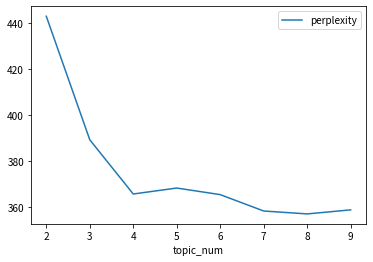

In [ ]:
result.plot.line(x='topic_num', y='perplexity')

<AxesSubplot:xlabel='topic_num'>

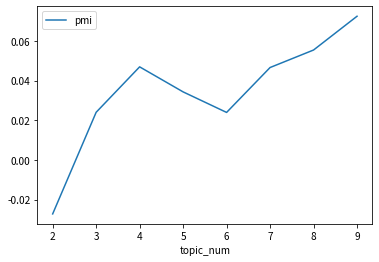

In [ ]:
result.plot.line(x='topic_num', y='pmi')

>就訓練結果來看，perplexity 在 4 之後都不錯，coherence 最高則是 9

##  視覺化呈現

### 產生 LDAvis 結果

>以下用主題數 9 來做 LDAvis 的結果範例

In [ ]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 9,
    id2word=dictionary,
    random_state = 1500,
    passes = 20 # 訓練次數
    )

2023-06-08 13:05:54,790 : INFO : using symmetric alpha at 0.1111111111111111
2023-06-08 13:05:54,790 : INFO : using symmetric eta at 0.1111111111111111
2023-06-08 13:05:54,792 : INFO : using serial LDA version on this node
2023-06-08 13:05:54,793 : INFO : running online (multi-pass) LDA training, 9 topics, 20 passes over the supplied corpus of 1500 documents, updating model once every 1500 documents, evaluating perplexity every 1500 documents, iterating 50x with a convergence threshold of 0.001000
2023-06-08 13:05:55,588 : INFO : -7.303 per-word bound, 158.0 perplexity estimate based on a held-out corpus of 1500 documents with 97195 words
2023-06-08 13:05:55,589 : INFO : PROGRESS: pass 0, at document #1500/1500
2023-06-08 13:05:56,261 : INFO : topic #7 (0.111): 0.018*"電影" + 0.011*"時間" + 0.011*"喜歡" + 0.010*"劇情" + 0.010*"看到" + 0.008*"最後" + 0.008*"知道" + 0.008*"主角" + 0.006*"出現" + 0.006*"市場"
2023-06-08 13:05:56,262 : INFO : topic #2 (0.111): 0.019*"原文" + 0.018*"時間" + 0.011*"看到" + 0.010*"台灣"

In [ ]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.016924  0.160256       1        1  19.065515
4      0.114685  0.087553       2        1  17.597793
3      0.250988 -0.111788       3        1  13.886591
2     -0.255720 -0.131281       4        1  13.420322
1      0.216762 -0.025562       5        1  11.698610
5      0.202370 -0.076416       6        1   7.437692
0     -0.245270 -0.145855       7        1   6.491243
8     -0.104690  0.160053       8        1   6.105079
6     -0.196048  0.083039       9        1   4.297155, topic_info=    Term        Freq        Total Category  logprob  loglift
681   電影  810.000000   810.000000  Default  30.0000  30.0000
75    公司  750.000000   750.000000  Default  29.0000  29.0000
8     原文  769.000000   769.000000  Default  28.0000  28.0000
39    工作  358.000000   358.000000  Default  27.0000  27.0000
276  台積電  253.000000   253.000000  Default  26.0000  26.0000
..   ...         ...          ...      ...      ...      ...
275   使用   39.388347   256.966066   Topic9  -4.6638   1.2717
47    目前   54.365445   496.682270   Topic9  -4.3415   0.9350
174   相關   29.081369   207.341447   Topic9  -4.9672   1.1829
44    時間   41.913033  1576.863906   Topic9  -4.6017  -0.4804
194   機會   29.990333   262.536489   Topic9  -4.9364   0.9777

[453 rows x 6 columns], token_table=      Topic      Freq Term
term                      
61        1  0.243176   一下
61        2  0.374992   一下
61        3  0.043181   一下
61        4  0.011363   一下
61        5  0.159087   一下
...     ...       ...  ...
605       6  0.055358   麵條
553       2  0.033795   點餐
553       3  0.430882   點餐
553       5  0.464677   點餐
553       6  0.067589   點餐

[1657 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 4, 3, 2, 6, 1, 9, 7])

>##### 上面使用主題9來進行LDAvis得出的結果中，主題4和7完全重疊，因此決定減少一個主題樹看看成果

In [ ]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 8,
    id2word=dictionary,
    random_state = 1500,
    passes = 20 # 訓練次數
    )

2023-06-08 13:07:51,936 : INFO : using symmetric alpha at 0.125
2023-06-08 13:07:51,937 : INFO : using symmetric eta at 0.125
2023-06-08 13:07:51,938 : INFO : using serial LDA version on this node
2023-06-08 13:07:51,939 : INFO : running online (multi-pass) LDA training, 8 topics, 20 passes over the supplied corpus of 1500 documents, updating model once every 1500 documents, evaluating perplexity every 1500 documents, iterating 50x with a convergence threshold of 0.001000
2023-06-08 13:07:52,802 : INFO : -7.278 per-word bound, 155.2 perplexity estimate based on a held-out corpus of 1500 documents with 97195 words
2023-06-08 13:07:52,803 : INFO : PROGRESS: pass 0, at document #1500/1500
2023-06-08 13:07:53,473 : INFO : topic #4 (0.125): 0.016*"時間" + 0.012*"公司" + 0.011*"最後" + 0.009*"看到" + 0.009*"電影" + 0.008*"拉麵" + 0.007*"好吃" + 0.007*"工作" + 0.006*"知道" + 0.006*"一下"
2023-06-08 13:07:53,474 : INFO : topic #0 (0.125): 0.018*"最後" + 0.013*"原文" + 0.013*"電影" + 0.013*"公司" + 0.012*"股東" + 0.010*"看到"

In [ ]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.207514 -0.078626       1        1  25.060703
7      0.001549  0.199229       2        1  19.238320
4      0.105033  0.113908       3        1  15.765634
2     -0.274260 -0.080454       4        1  15.295816
6     -0.124213  0.113695       5        1   7.716875
0     -0.274780 -0.098409       6        1   6.798442
1      0.176565  0.003392       7        1   5.955900
3      0.182590 -0.172734       8        1   4.168311, topic_info=    Term        Freq        Total Category  logprob  loglift
681   電影  810.000000   810.000000  Default  30.0000  30.0000
75    公司  742.000000   742.000000  Default  29.0000  29.0000
8     原文  779.000000   779.000000  Default  28.0000  28.0000
525   飯店  336.000000   336.000000  Default  27.0000  27.0000
39    工作  350.000000   350.000000  Default  26.0000  26.0000
..   ...         ...          ...      ...      ...      ...
419   餐廳   54.329081   528.780860   Topic8  -4.3118   0.9021
44    時間   63.988905  1577.536620   Topic8  -4.1481  -0.0273
533   圖文   32.562395   274.078277   Topic8  -4.8237   1.0474
534   地址   33.469573   407.021959   Topic8  -4.7962   0.6794
459   電話   32.494459   331.255271   Topic8  -4.8257   0.8558

[404 rows x 6 columns], token_table=      Topic      Freq Term
term                      
61        1  0.160832   一下
61        2  0.248141   一下
61        3  0.351533   一下
61        4  0.018381   一下
61        5  0.110285   一下
...     ...       ...  ...
552       7  0.449648   麵包
552       8  0.335331   麵包
605       1  0.894737   麵條
605       3  0.077323   麵條
605       8  0.022092   麵條

[1413 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 8, 5, 3, 7, 1, 2, 4])

> ##### 縮減後主題4和6依然重複性很高，分別查看其他各個主題的內容，發現主題1,7,8的內容相近，都和美食、餐廳推薦相關，再參考前面計算出的perplexity，因此決定縮小主題數至4，並提高訓練次數

In [ ]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 4,
    id2word=dictionary,
    random_state = 1500,
    passes = 25 # 訓練次數
    )

2023-06-08 13:19:27,950 : INFO : using symmetric alpha at 0.25
2023-06-08 13:19:27,951 : INFO : using symmetric eta at 0.25
2023-06-08 13:19:27,952 : INFO : using serial LDA version on this node
2023-06-08 13:19:27,953 : INFO : running online (multi-pass) LDA training, 4 topics, 25 passes over the supplied corpus of 1500 documents, updating model once every 1500 documents, evaluating perplexity every 1500 documents, iterating 50x with a convergence threshold of 0.001000
2023-06-08 13:19:28,837 : INFO : -7.138 per-word bound, 140.8 perplexity estimate based on a held-out corpus of 1500 documents with 97195 words
2023-06-08 13:19:28,838 : INFO : PROGRESS: pass 0, at document #1500/1500
2023-06-08 13:19:29,528 : INFO : topic #0 (0.250): 0.016*"最後" + 0.014*"電影" + 0.010*"公司" + 0.009*"看到" + 0.008*"原文" + 0.008*"時間" + 0.008*"知道" + 0.008*"股東" + 0.006*"市場" + 0.006*"角色"
2023-06-08 13:19:29,529 : INFO : topic #1 (0.250): 0.019*"時間" + 0.012*"公司" + 0.007*"喜歡" + 0.007*"感覺" + 0.006*"知道" + 0.006*"口感" +

In [ ]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.189717 -0.131116       1        1  33.380564
2      0.285999 -0.070033       2        1  24.228816
1     -0.072842  0.002642       3        1  22.069046
0     -0.023440  0.198507       4        1  20.321575, topic_info=    Term        Freq       Total Category  logprob  loglift
681   電影  812.000000  812.000000  Default  30.0000  30.0000
8     原文  773.000000  773.000000  Default  29.0000  29.0000
75    公司  745.000000  745.000000  Default  28.0000  28.0000
728   劇情  319.000000  319.000000  Default  27.0000  27.0000
532   口感  465.000000  465.000000  Default  26.0000  26.0000
..   ...         ...         ...      ...      ...      ...
116   一直  137.393770  312.474083   Topic4  -4.9681   0.7718
60    資訊  115.035925  217.332568   Topic4  -5.1457   0.9573
15    現在  121.743696  332.364250   Topic4  -5.0891   0.5892
61    一下  112.442441  438.647110   Topic4  -5.1685   0.2322
111   問題  108.128375  272.882091   Topic4  -5.2077   0.6678

[238 rows x 6 columns], token_table=      Topic      Freq Term
term                      
61        1  0.234813   一下
61        2  0.025077   一下
61        3  0.485584   一下
61        4  0.255331   一下
599       1  0.994381   一口
...     ...       ...  ...
582       3  0.005147   香氣
605       1  0.981673   麵條
605       3  0.011030   麵條
553       1  0.986715   點餐
553       3  0.008506   點餐

[457 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 1])

>##### 這次的分類相較前幾次就比較好，可以清楚分辨出各主題的內容：
- 主題一：餐廳/食物
- 主題二：全球產業/股市
- 主題三：日本旅遊
- 主題四：電影

In [ ]:
pyLDAvis.save_html(p, "lda_zh.html")

## GuidedLDA

In [ ]:
import guidedlda

In [ ]:
vocab = tuple(dictionary.token2id.keys())
vocab[:10]

('一年', '三個', '不錯', '主管', '今年', '兩個', '分享', '印象', '原文', '參考')

In [ ]:
word2id = dictionary.token2id

In [ ]:
seed_topic_list = [
    [
        '公司', '工作', '工程師', '面試', '薪資', '主管', '前輩', '薪水', '加班', '年薪', '職位', 
        '部門', '科技', '大學', '單位', '發展',  '管理', '客戶', '產業',
        '現職', '調薪', '電子', '老闆', '轉職', '製程', '系統', '出差', '同事', '系統廠', '企業',
        '新竹', '背景', '加班費', '員工', '下班', '離職', '績效', '月薪', '通勤', '人資', '年終', '福利',
        '裁員', '年資', '辦公室', '發展性', '軟體', '台積電', '技術', '跳槽',
    ],
    [
        '餐廳', '口感', '好吃', '吃起來', '營業', '消費', '味道', '用餐', '口味', '店家', '搭配', '價位', '餐點', 
        '菜單', '甜點', '香氣', '咖啡', '菜色', '店內', '價格', '份量', '美味', '料理', '刷卡', '套餐', '吃到飽', 
        '牛排', '包廂', '環境', '美食', '招牌', '蛋糕', '品項', '海鮮', '雞肉', '麵包', '調味', '豆腐', '小菜', '客人', 
        '沙拉', '飲料', '湯頭', '食材', '火鍋', '空間', '醬汁', '點餐', '新鮮', '服務', '豬肉', '風味', '座位', '公休', 
        '濃湯', '豐富', '蔬菜', '飲品', '濃郁', '雞腿', '酥脆', '老闆', '清爽', '蛤蜊', '軟嫩', '便當', '滋味', '吃完', 
        '奶油', '饅頭', '吃過', '檸檬', '外帶', '巧克力', '冰淇淋', '肉質', '起司', '配料', '泰式', '配菜', '特色', '外皮', 
        '排隊', '炸雞', '傳統', '原味', '燉飯', '早餐',
    ],
    [
        '市場', '發布', '美國', '億元', '投資', '台積電', '股東', '營收', '銀行', '台灣', '中國', '經濟', '台股', '半導體', 
        '股利', '持續', '預期', '股價', '指數', '影響', '全球', '成長', '產業', '獲利', '晶片', '現金', '股票', '億美', '美元', 
        '政策', '基金', '升息', '外資', '通膨', '董事長', '金融', '第季', '表現', '企業', '大陸', '政府', '奈米', '業者', '新光金', 
        '董事', '增加', '價格', '投資人', '上市', '景氣', '發展', '下半年', '生產', '營運', '資本', '每股', '預估', '股市', '庫存', 
        '蘋果', '上漲', '資金', '股東會', '國際', '衰退', '調整', '成本', '金管會', '泰山', '交易', '盈餘', '配息', '公布', '董事會', 
        '製程', '數據', '聯準會', '法人', '風險', '輝達', '業務', '利率', '美股', '長榮', '漲幅', '股息', '虧損',
    ],
    [
        '飯店', '日本', '車站', '神社', '造訪', '行程', '東京', '京都', '拉麵', '機場', '排隊', '北海道', '推薦', '札幌', '景點',
        '抵達', '巴士', '台灣', '櫻花', '大阪', '住宿', '日幣', '博多', '抹茶', '行李', '溫泉', '旅館', '體驗', '預約', '纜車', 
        '仙台', '入住', '烏龍麵', '入境', '福岡', '醬油', '壽司', '函館', '牛肉', '鰻魚', '飛機', '日文', '神宮', '旅行', 
        '燒肉', '富士山', '遊客', '電車', '球場', '富山', '日式', '海鮮', '牛舌', '叉燒', '名古屋', '旅伴', '吃到飽', '醬汁', '熊本', 
        '冰淇淋', '羽田', '新幹線', '定食',
    ],
    [
        '電影', '劇情', '角色', '這部', '主角', '故事', '雷文', '觀眾', '防雷', '畫面', '作品', '導演', '動畫', '漫畫', '一部',
        '主文', '鈴芽', '蟻人', '日本', '本片', '櫻木', '比賽', '新海', '好看', '系列', '節奏', '人物', '漫威',
        '三井', '電影院', '感動', '上映', '期待', '結局', '反派', '設定', '場景', '內容', '呈現', '名字', '情感', '電影版', 
        '高手', '劇場版', '整部', '灌籃', '有趣', '演員', '經典', '預告', '星際', '橋段', '那段', '真實', '音樂', '細節', '觀影', 
        '印象', '心得', '推薦', '特效', '風格', '台詞', '這片', '開頭', '背景', '動作', '完整', '靈魂', '異攻隊', '元素', '場面', 
        '原作', '票房', '結尾', '觀賞', '片段', '影片', '美國', '流川', '冒險', '井上', '事件', '兄弟', '改編', '戲院', '感受到', 
        '關鍵', '笑點', '想像', '感受', '評價', '類似', '製作', '進場', '對話', '英雄', '熱血', '劇本', '後續', '彩蛋'
    ]
]

In [ ]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        if word in word2id:
            seed_topics[word2id[word]] = t_id

In [ ]:
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

In [ ]:
model = guidedlda.GuidedLDA(n_topics=5, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2023-06-08 13:30:36,973 : INFO : n_documents: 1500
2023-06-08 13:30:36,974 : INFO : vocab_size: 734
2023-06-08 13:30:36,974 : INFO : n_words: 97195
2023-06-08 13:30:36,975 : INFO : n_topics: 5
2023-06-08 13:30:36,975 : INFO : n_iter: 100
2023-06-08 13:30:36,977 : WARNING : all zero row in document-term matrix found
2023-06-08 13:30:37,178 : INFO : <0> log likelihood: -743673
2023-06-08 13:30:37,285 : INFO : <20> log likelihood: -591043
2023-06-08 13:30:37,389 : INFO : <40> log likelihood: -588173
2023-06-08 13:30:37,533 : INFO : <60> log likelihood: -587528
2023-06-08 13:30:37,642 : INFO : <80> log likelihood: -587434
2023-06-08 13:30:37,750 : INFO : <99> log likelihood: -587125


In [ ]:
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 公司 工作 目前 小弟 內容 工程師 薪資 問題 主管 面試
Topic 1: 時間 餐廳 口感 好吃 地址 營業 吃起來 口味 味道 店家
Topic 2: 原文 市場 今年 公司 記者 表示 時間 去年 美國 發布
Topic 3: 飯店 日本 時間 看到 車站 神社 行程 東京 造訪 京都
Topic 4: 電影 最後 劇情 知道 角色 看到 這部 喜歡 故事 主角


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.213050  0.156493       1        1  32.259770
2      0.275520  0.137072       2        1  21.708245
4     -0.044059 -0.124733       3        1  20.373839
3     -0.147947 -0.043062       4        1  17.661175
0      0.129536 -0.125771       5        1   7.996970, topic_info=    Term        Freq        Total Category  logprob  loglift
681   電影  816.000000   816.000000  Default  30.0000  30.0000
75    公司  750.000000   750.000000  Default  29.0000  29.0000
8     原文  777.000000   777.000000  Default  28.0000  28.0000
39    工作  359.000000   359.000000  Default  27.0000  27.0000
525   飯店  348.000000   348.000000  Default  26.0000  26.0000
..   ...         ...          ...      ...      ...      ...
6     分享   68.959564   219.950625   Topic5  -4.7248   1.3662
126   產品   66.961026   209.953493   Topic5  -4.7543   1.3833
40    希望   65.961757   207.948293   Topic5  -4.7693   1.3779
44    時間   69.958833  1585.501528   Topic5  -4.7105  -0.5946
34    台灣   63.963218   525.851260   Topic5  -4.8001   0.4194

[273 rows x 6 columns], token_table=      Topic      Freq Term
term                      
61        1  0.203674   一下
61        2  0.013578   一下
61        3  0.253461   一下
61        4  0.416401   一下
61        5  0.113152   一下
...     ...       ...  ...
419       3  0.005662   餐廳
419       4  0.020760   餐廳
550       1  1.000143   餐點
582       1  1.000076   香氣
553       1  0.999906   點餐

[538 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 5, 4, 1])

In [ ]:
seed_topic_list = [
    [
        '公司', '工作', '工程師', '面試', '薪資', '主管', '前輩', '薪水', '加班', '年薪', '職位', '工時', 
        '部門', '科技業', '科技', '職缺', '大學', '單位', '上班', '發展', '外商', '管理', '客戶', '產業',
        '獎金', '現職', '調薪', '電子', '老闆', '轉職', '製程', '系統', '出差', '同事', '系統廠', '企業',
        '新竹', '背景', '加班費', '員工', '下班', '離職', '績效', '月薪', '通勤', '人資', '年終', '福利',
        '裁員', '年資', '辦公室', '發展性', '軟體', '台積電', '技術', '跳槽',
    ],
    [
        '餐廳', '口感', '好吃', '吃起來', '營業', '消費', '味道', '用餐', '口味', '店家', '搭配', '價位', '餐點', 
        '菜單', '甜點', '香氣', '咖啡', '菜色', '店內', '價格', '份量', '美味', '料理', '刷卡', '套餐', '吃到飽', 
        '牛排', '包廂', '環境', '美食', '招牌', '蛋糕', '品項', '海鮮', '雞肉', '麵包', '調味', '豆腐', '小菜', '客人', 
        '沙拉', '飲料', '湯頭', '食材', '火鍋', '空間', '醬汁', '點餐', '新鮮', '服務', '豬肉', '風味', '座位', '公休', 
        '濃湯', '豐富', '蔬菜', '飲品', '濃郁', '雞腿', '酥脆', '老闆', '清爽', '蛤蜊', '軟嫩', '便當', '滋味', '吃完', 
        '奶油', '饅頭', '吃過', '檸檬', '外帶', '巧克力', '冰淇淋', '肉質', '起司', '配料', '泰式', '配菜', '特色', '外皮', 
        '排隊', '炸雞', '傳統', '原味', '燉飯', '早餐',
    ],
    [
        '市場', '發布', '美國', '億元', '投資', '台積電', '股東', '營收', '銀行', '台灣', '中國', '經濟', '台股', '半導體', 
        '股利', '持續', '預期', '股價', '指數', '影響', '全球', '成長', '產業', '獲利', '晶片', '現金', '股票', '億美', '美元', 
        '政策', '基金', '升息', '外資', '通膨', '董事長', '金融', '第季', '表現', '企業', '大陸', '政府', '奈米', '業者', '新光金', 
        '董事', '增加', '價格', '投資人', '上市', '景氣', '發展', '下半年', '生產', '營運', '資本', '每股', '預估', '股市', '庫存', 
        '蘋果', '上漲', '資金', '股東會', '國際', '衰退', '調整', '成本', '金管會', '泰山', '交易', '盈餘', '配息', '公布', '董事會', 
        '製程', '數據', '聯準會', '法人', '風險', '輝達', '業務', '利率', '美股', '長榮', '漲幅', '股息', '虧損',
    ],
    [
        '飯店', '日本', '車站', '神社', '造訪', '行程', '東京', '京都', '拉麵', '機場', '排隊', '北海道', '推薦', '札幌', '景點',
        '抵達', '巴士', '台灣', '櫻花', '大阪', '住宿', '日幣', '博多', '抹茶', '行李', '溫泉', '旅館', '體驗', '預約', '纜車', 
        '仙台', '入住', '烏龍麵', '入境', '福岡', '醬油', '壽司', '函館', '牛肉', '鰻魚', '飛機', '日文', '神宮', '旅行', 
        '燒肉', '富士山', '遊客', '電車', '球場', '富山', '日式', '海鮮', '牛舌', '叉燒', '名古屋', '旅伴', '吃到飽', '醬汁', '熊本', 
        '冰淇淋', '羽田', '新幹線', '定食',
    ],
    [
        '電影', '劇情', '角色', '這部', '主角', '故事', '雷文', '觀眾', '防雷', '畫面', '作品', '導演', '動畫', '漫畫', '一部',
        '主文', '鈴芽', '蟻人', '日本', '本片', '櫻木', '比賽', '新海', '好看', '系列', '節奏', '人物', '漫威',
        '三井', '電影院', '感動', '上映', '期待', '結局', '反派', '設定', '場景', '內容', '呈現', '名字', '情感', '電影版', 
        '高手', '劇場版', '整部', '灌籃', '有趣', '演員', '經典', '預告', '星際', '橋段', '那段', '真實', '音樂', '細節', '觀影', 
        '印象', '心得', '推薦', '特效', '風格', '台詞', '這片', '開頭', '背景', '動作', '完整', '靈魂', '異攻隊', '元素', '場面', 
        '原作', '票房', '結尾', '觀賞', '片段', '影片', '美國', '流川', '冒險', '井上', '事件', '兄弟', '改編', '戲院', '感受到', 
        '關鍵', '笑點', '想像', '感受', '評價', '類似', '製作', '進場', '對話', '英雄', '熱血', '劇本', '後續', '彩蛋'
    ]
]

seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        if word in word2id:
            seed_topics[word2id[word]] = t_id

In [ ]:
model = guidedlda.GuidedLDA(n_topics=5, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2023-06-08 13:31:32,768 : INFO : n_documents: 1500
2023-06-08 13:31:32,769 : INFO : vocab_size: 734
2023-06-08 13:31:32,769 : INFO : n_words: 97195
2023-06-08 13:31:32,770 : INFO : n_topics: 5
2023-06-08 13:31:32,770 : INFO : n_iter: 100
2023-06-08 13:31:32,772 : WARNING : all zero row in document-term matrix found
2023-06-08 13:31:32,980 : INFO : <0> log likelihood: -743673
2023-06-08 13:31:33,103 : INFO : <20> log likelihood: -591043
2023-06-08 13:31:33,213 : INFO : <40> log likelihood: -588173
2023-06-08 13:31:33,328 : INFO : <60> log likelihood: -587528
2023-06-08 13:31:33,444 : INFO : <80> log likelihood: -587434
2023-06-08 13:31:33,574 : INFO : <99> log likelihood: -587125


In [ ]:
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 公司 工作 目前 小弟 內容 工程師 薪資 問題 主管 面試
Topic 1: 時間 餐廳 口感 好吃 地址 營業 吃起來 口味 味道 店家
Topic 2: 原文 市場 今年 公司 記者 表示 時間 去年 美國 發布
Topic 3: 飯店 日本 時間 看到 車站 神社 行程 東京 造訪 京都
Topic 4: 電影 最後 劇情 知道 角色 看到 這部 喜歡 故事 主角


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.213050  0.156493       1        1  32.259770
2      0.275520  0.137072       2        1  21.708245
4     -0.044059 -0.124733       3        1  20.373839
3     -0.147947 -0.043062       4        1  17.661175
0      0.129536 -0.125771       5        1   7.996970, topic_info=    Term        Freq        Total Category  logprob  loglift
681   電影  816.000000   816.000000  Default  30.0000  30.0000
75    公司  750.000000   750.000000  Default  29.0000  29.0000
8     原文  777.000000   777.000000  Default  28.0000  28.0000
39    工作  359.000000   359.000000  Default  27.0000  27.0000
525   飯店  348.000000   348.000000  Default  26.0000  26.0000
..   ...         ...          ...      ...      ...      ...
6     分享   68.959564   219.950625   Topic5  -4.7248   1.3662
126   產品   66.961026   209.953493   Topic5  -4.7543   1.3833
40    希望   65.961757   207.948293   Topic5  -4.7693   1.3779
44    時間   69.958833  1585.501528   Topic5  -4.7105  -0.5946
34    台灣   63.963218   525.851260   Topic5  -4.8001   0.4194

[273 rows x 6 columns], token_table=      Topic      Freq Term
term                      
61        1  0.203674   一下
61        2  0.013578   一下
61        3  0.253461   一下
61        4  0.416401   一下
61        5  0.113152   一下
...     ...       ...  ...
419       3  0.005662   餐廳
419       4  0.020760   餐廳
550       1  1.000143   餐點
582       1  1.000076   香氣
553       1  0.999906   點餐

[538 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 5, 4, 1])

## 主題分佈的應用，搭配其他文章資訊

In [ ]:
# 取得每條新聞的主題分佈
topics_doc = best_model.get_document_topics(corpus)

In [ ]:
topics_doc[100]

[(0, 0.5557961), (1, 0.012661823), (2, 0.41952342), (3, 0.012018705)]

In [ ]:
m_theta = corpus2csc(topics_doc).T.toarray()
m_theta

array([[0.        , 0.8565051 , 0.12435794, 0.        ],
       [0.35562104, 0.03059383, 0.58534628, 0.0284389 ],
       [0.        , 0.4049671 , 0.58248228, 0.        ],
       ...,
       [0.98438972, 0.        , 0.        , 0.        ],
       [0.99259955, 0.        , 0.        , 0.        ],
       [0.98796713, 0.        , 0.        , 0.        ]])

In [ ]:
udn['topic_label'] = m_theta.argmax(axis=1) + 1

In [ ]:
udn['topic_label'].value_counts()

topic_label
2    449
4    377
3    339
1    335
Name: count, dtype: int64

In [ ]:
udn.head()

,content,artUrl,artCatagory,artDate,words,topic_label
0,轉貼醋院的薪水分享節錄部分科技業爆發前進去醋院第一年未滿一年本薪餐補年中年終調薪考績第二年滿...,https://www.ptt.cc/bbs/Tech_Job/M.1675310634.A...,Tech_Job,2023-02-02 12:03:52,"[轉貼, 醋院, 薪水, 分享, 節錄, 科技業, 爆發, 前進, 醋院, 第一年, 未滿,...",2
1,嗨囉我就機械仔雖然修完但出社會後依然面對現實最近拿到的都是半導體方面的設備機構該選哪個勒還是轉生,https://www.ptt.cc/bbs/Tech_Job/M.1683208121.A...,Tech_Job,2023-05-04 21:48:39,"[機械, 修完, 但出, 社會, 依然, 面對, 現實, 最近, 拿到, 半導體, 方面, ...",3
2,各位新年好這裡是國立政治大學心理學研究所系工商心理學組的碩士班研究生目前正在進行碩士論文的研...,https://www.ptt.cc/bbs/Tech_Job/M.1674480733.A...,Tech_Job,2023-01-23 21:32:11,"[新年, 國立, 政治, 大學, 心理學, 研究所, 工商, 心理學, 碩士班, 研究生, ...",3
3,各位年薪三百的大大好想請問有沒有聽過衡陞科技的大大在站上或估狗爬文都找不太到資訊想問問裡面風...,https://www.ptt.cc/bbs/Tech_Job/M.1676493334.A...,Tech_Job,2023-02-16 04:35:32,"[年薪, 三百, 請問, 有沒有, 過衡, 科技, 站上, 估狗, 爬文, 不太到, 資訊,...",2
4,最近來一位姑且稱長官專案成員中跟能力接近但不得長官心因為他之前開會直接嗆長官的話有大奶優勢加...,https://www.ptt.cc/bbs/Tech_Job/M.1682945779.A...,Tech_Job,2023-05-01 20:56:14,"[最近, 一位, 長官, 專案, 成員, 能力, 接近, 長官, 開會, 直接, 長官, 大...",1


In [ ]:
udn['artDate'] = pd.to_datetime(udn['artDate'])


In [ ]:
udn['artDate'].dt.date

0       2023-02-02
1       2023-05-04
2       2023-01-23
3       2023-02-16
4       2023-05-01
           ...    
1495    2023-02-18
1496    2023-01-14
1497    2023-05-25
1498    2023-04-16
1499    2023-01-30
Name: artDate, Length: 1500, dtype: object

In [ ]:
udn.groupby(udn['artDate'].dt.date)['topic_label'].value_counts(normalize=True)

artDate     topic_label
2023-01-01  1              1.000000
2023-01-02  1              0.666667
            2              0.333333
2023-01-03  4              0.333333
            2              0.333333
                             ...   
2023-05-30  1              0.071429
2023-05-31  3              0.500000
            2              0.312500
            4              0.125000
            1              0.062500
Name: proportion, Length: 484, dtype: float64

In [ ]:
date_topic = udn.groupby(udn['artDate'].dt.date)['topic_label'].value_counts(normalize=True).unstack()
date_topic.head()

topic_label,1,2,3,4
artDate,,,,
2023-01-01,1.000000,NaN,NaN,NaN
2023-01-02,0.666667,0.333333,NaN,NaN
2023-01-03,0.333333,0.333333,NaN,0.333333
2023-01-04,0.333333,0.500000,NaN,0.166667
2023-01-05,NaN,0.833333,NaN,0.166667


<AxesSubplot:xlabel='artDate'>

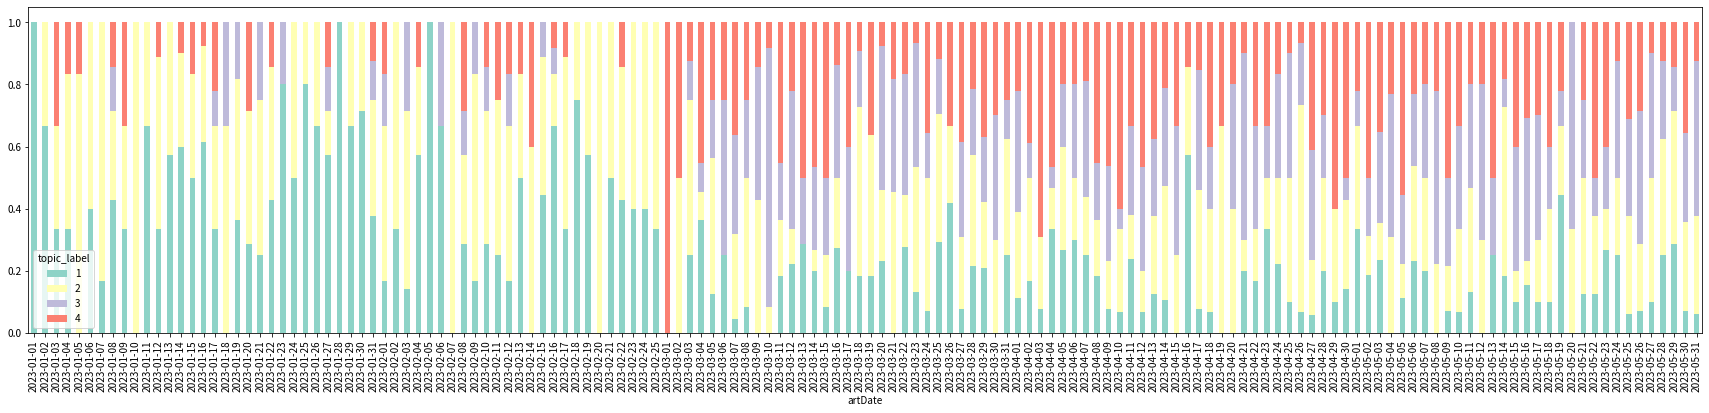

In [ ]:
fig, ax = plt.subplots(figsize=(30, 6))
date_topic.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)

>透過搭配文章的資訊（例如日期等），可以讓主題模型的結果做出更多的分析應用
根據前面的LDA：
- 主題一：餐廳/食物
- 主題二：全球產業/股市
- 主題三：日本旅遊
- 主題四：電影

>從上圖可以發現一個趨勢，有關日本旅遊、電影的這兩個主題的貼文比例，在2月後大幅增加，推斷可能是因為疫情趨緩，政府防疫政策放寬，大家漸漸開始外出。



## **(3)社會網路分析**

>以PTT電影板2023/01/01至2023/06/01的發文作為資料來源，觀察這段時間受到關注的電影角色和演員有哪些。

In [ ]:
! pip install pyvis networkx pandas numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import pyvis
import networkx as nx
import IPython
import codecs

import random
from itertools import combinations
import re
import net_func

import jieba
import jieba.posseg as pseg
import jieba.analyse as analyse


In [ ]:
raw_data = pd.read_csv('./raw_data/Movie.csv')
raw_data.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/movie/M.1672508082.A.B7...,[負雷]阿凡達2看到想快轉,2023-01-01 01:34:39,dog9527,movie,雷文防雷資訊頁\n\n\n\n~*-*~*-*~*-*~*-*~*-*~*-*~*-*~*-...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""ginopun10477...",39.9.43.245,2023-01-01 01:55:01,ptt
1,2,https://www.ptt.cc/bbs/movie/M.1672515362.A.27...,[好雷]灌籃高手～可開始期待Thesecond澤北,2023-01-01 03:36:00,chinaciv,movie,好像標題就爆劇情雷？\n\n先來驗明正身\nhttps://i.imgur.com/WMrb...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""GalaxySII"", ...",223.137.41.19,2023-01-02 01:55:40,ptt
2,3,https://www.ptt.cc/bbs/movie/M.1672516182.A.5B...,[好雷]《灌籃高手》賦予全新生命的灌高,2023-01-01 03:49:38,fangfangki,movie,看到當初釋出畫面時的擔憂\n看到日本票房跟評價時的困惑\n但當看到流川楓爆扣時，這些都已不存...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""glacierl"", ""...",116.89.139.10,2023-01-02 01:55:40,ptt
3,4,https://www.ptt.cc/bbs/movie/M.1672518482.A.AA...,[普好雷]宮城前傳-灌籃高手2023劇場版感想,2023-01-01 04:27:58,j3307002,movie,"本來2023.1.13才要正式上灌籃高手,但有跨年特別場就決定去看,我是在台北市微風影城\n...","[{""cmtStatus"": ""推"", ""cmtPoster"": ""kyosukeakiba...",111.250.14.185,2023-01-02 01:55:40,ptt
4,5,https://www.ptt.cc/bbs/movie/M.1672518723.A.A9...,[好雷]灌籃高手,2023-01-01 04:32:01,anti56,movie,先說結論 好看！\n\n3D不至於覺得怪 看幾分鐘適應之後其實很加分！\n\n老觀眾該感動...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""j3307002"", ""...",124.218.229.181,2023-01-02 01:55:40,ptt


In [ ]:
# 移除網址格式
raw_data["artContent"] = raw_data.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", str(x))
)
raw_data["artTitle"] = raw_data["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
raw_data["artContent"] = raw_data.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
raw_data["artTitle"] = raw_data["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)

# 留下 content
raw_data["content"] = raw_data["artTitle"] + raw_data["artContent"]
raw_data = raw_data[["content", "artUrl"]] 
raw_data.head()

,content,artUrl
0,負雷阿凡達看到想快轉雷文防雷資訊頁雷文主文分隔線最近到桃園的新光影城看的特效的部分就不多說針...,https://www.ptt.cc/bbs/movie/M.1672508082.A.B7...
1,好雷灌籃高手可開始期待澤北好像標題就爆劇情雷先來驗明正身跨年場可獲得恭喜啦抽得魔關羽不是大猩...,https://www.ptt.cc/bbs/movie/M.1672515362.A.27...
2,好雷灌籃高手賦予全新生命的灌高看到當初釋出畫面時的擔憂看到日本票房跟評價時的困惑但當看到流川...,https://www.ptt.cc/bbs/movie/M.1672516182.A.5B...
3,普好雷宮城前傳灌籃高手劇場版感想本來才要正式上灌籃高手但有跨年特別場就決定去看我是在台北市微...,https://www.ptt.cc/bbs/movie/M.1672518482.A.AA...
4,好雷灌籃高手先說結論好看不至於覺得怪看幾分鐘適應之後其實很加分老觀眾該感動的有讓老觀眾有新感...,https://www.ptt.cc/bbs/movie/M.1672518723.A.A9...


In [ ]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

with open("./dict/character_names.txt", "r", encoding="utf-8") as f:
    character_names = [line.strip() for line in f.readlines()]

with open("./dict/movie_2023.txt", "r", encoding="utf-8") as f:
    movie_2023 = [line.strip() for line in f.readlines()]

# 新增自定義詞語(角色名稱、電影名稱)
for word in character_names:
    jieba.add_word(word)

for word in movie_2023:
    jieba.add_word(word)

# 新增stopwords
jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

with open("./dict/user_stopwords.txt", encoding="utf-8") as f:
    userStopWords = [line.strip() for line in f.readlines()]

# 合併停用詞列表
stopWords += userStopWords

# 執行斷詞
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [w for w in seg_list if w not in stopWords and len(w) > 1]
    return seg_list

Building prefix dict from /content/drive/MyDrive/Colab Notebooks/w14/dict/dict.txt.big ...
DEBUG:jieba:Building prefix dict from /content/drive/MyDrive/Colab Notebooks/w14/dict/dict.txt.big ...
Loading model from cache /tmp/jieba.u004a29af76ca27c8354d630d7dcb2d7c.cache
DEBUG:jieba:Loading model from cache /tmp/jieba.u004a29af76ca27c8354d630d7dcb2d7c.cache
Loading model cost 1.537 seconds.
DEBUG:jieba:Loading model cost 1.537 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


In [ ]:
#標題與內文合併斷詞
raw_data["words"] = raw_data["content"].apply(getToken).map(" ".join)
raw_data.head()

,content,artUrl,words
0,負雷阿凡達看到想快轉雷文防雷資訊頁雷文主文分隔線最近到桃園的新光影城看的特效的部分就不多說針...,https://www.ptt.cc/bbs/movie/M.1672508082.A.B7...,阿凡達 看到 想快 轉雷文 資訊 最近 桃園 光影 城看 特效 部分 針對 劇情 部分 實在...
1,好雷灌籃高手可開始期待澤北好像標題就爆劇情雷先來驗明正身跨年場可獲得恭喜啦抽得魔關羽不是大猩...,https://www.ptt.cc/bbs/movie/M.1672515362.A.27...,灌籃高手 期待 澤北 好像 標題 劇情 先來 驗明正身 跨年場 獲得 恭喜 抽得 關羽 大猩...
2,好雷灌籃高手賦予全新生命的灌高看到當初釋出畫面時的擔憂看到日本票房跟評價時的困惑但當看到流川...,https://www.ptt.cc/bbs/movie/M.1672516182.A.5B...,灌籃高手 賦予 全新 生命 灌高 看到 當初 釋出 畫面 擔憂 看到 日本 票房 評價 困惑...
3,普好雷宮城前傳灌籃高手劇場版感想本來才要正式上灌籃高手但有跨年特別場就決定去看我是在台北市微...,https://www.ptt.cc/bbs/movie/M.1672518482.A.AA...,宮城 前傳 灌籃高手 劇場版 感想 正式 灌籃高手 特別 場就 決定 台北市 微風 影城 看...
4,好雷灌籃高手先說結論好看不至於覺得怪看幾分鐘適應之後其實很加分老觀眾該感動的有讓老觀眾有新感...,https://www.ptt.cc/bbs/movie/M.1672518723.A.A9...,灌籃高手 先說 結論 好看 覺得 幾分鐘 適應 之後 很加分 老觀 眾該 感動 觀眾 新感受...


In [ ]:
character_names.append('傑森史塔克')
character_names += movie_2023
character_names

['詹姆斯',
 '詹姆斯卡麥隆',
 '卡麥隆',
 '蘇傑克',
 '奈蒂莉',
 '綺莉',
 '小美人魚',
 '愛麗兒',
 '艾莉兒',
 '烏蘇拉',
 '艾瑞克',
 '川頓',
 '川頓國王',
 '賽巴斯汀',
 '比目魚',
 '史考托',
 '宮城良田',
 '木暮公延',
 '赤木晴子',
 '赤木剛憲',
 '櫻木花道',
 '流川楓',
 '三井壽',
 '納美人',
 '黃雨萱',
 '莫俊傑',
 '王詮勝',
 '李子維',
 '陳韻如',
 '鞋貓',
 '吉蒂',
 '佩洛',
 '鞋貓劍客',
 '舒莉',
 '黑豹',
 '納摩',
 '庫庫爾坎',
 '王太后',
 '奧科耶',
 '娜奇雅',
 '莉莉威廉斯',
 '莉莉',
 '恩巴庫',
 '傑克',
 '梅根',
 '彼得',
 '克里斯汀貝爾',
 '克里斯汀',
 '貝爾',
 '史匹伯',
 '馮迪索',
 '肥迪索',
 '迪索',
 '唐老大',
 '糖老大',
 '蘇菲',
 '卡倫',
 '傑森摩莫亞',
 '但丁',
 '芮斯',
 '吉賽兒',
 '水行俠',
 '莉蒂',
 '泰吉',
 '拉姆齊',
 '昆妮',
 '莎莉賽隆',
 '泰絲',
 '羅曼',
 '巨石強森',
 '賽芙',
 '神力女超人',
 '黑亞當',
 '蟻人',
 '馬利歐',
 '鈴芽',
 '黃蜂女',
 '閃電俠',
 '葛摩菈',
 '星爵',
 '涅布拉',
 '格魯特',
 '毀滅者',
 '德克斯',
 '螳螂女',
 '奎爾',
 '雷神索爾',
 '索爾',
 '岡恩',
 '柯南',
 '澤北榮治',
 '哈利波特',
 '基努李維',
 '蓋兒加朵',
 '約翰',
 '維克',
 '肯恩',
 '路易吉',
 '碧姬公主',
 '庫巴',
 '康拉德',
 '傑克康拉德',
 '詹姆士麥凱',
 '詹姆士',
 '麥凱',
 '妮莉拉洛伊',
 '妮莉',
 '拉洛伊',
 '唐華勒',
 '華勒',
 '查理',
 '艾莉',
 '白朗偵探',
 '岩戶鈴芽',
 '宗像草太',
 '岩戶環',
 '阿蕊',
 '塔爾',
 '埃德金',
 '達維斯',
 '霍爾嘉',
 '奇爾高雷',
 '贊柯',
 '葉恩德',
 '賽門',
 '奧

In [ ]:
#篩選出人名、電影名
def getPerson(sentence):
    names = []
    words = pseg.cut(sentence)
    for word, flag in words:
        if len(word) > 1 and (flag in 'nr' or word in character_names):
            names.append(word)
    return list(set(names))
    
raw_data['person'] = raw_data.words.apply(lambda r: getPerson(r))

raw_data

,content,artUrl,words,person
0,負雷阿凡達看到想快轉雷文防雷資訊頁雷文主文分隔線最近到桃園的新光影城看的特效的部分就不多說針...,https://www.ptt.cc/bbs/movie/M.1672508082.A.B7...,阿凡達 看到 想快 轉雷文 資訊 最近 桃園 光影 城看 特效 部分 針對 劇情 部分 實在...,[阿凡達]
1,好雷灌籃高手可開始期待澤北好像標題就爆劇情雷先來驗明正身跨年場可獲得恭喜啦抽得魔關羽不是大猩...,https://www.ptt.cc/bbs/movie/M.1672515362.A.27...,灌籃高手 期待 澤北 好像 標題 劇情 先來 驗明正身 跨年場 獲得 恭喜 抽得 關羽 大猩...,"[灌籃高手, 老爹, 西洽, 小三傳, 柯南, 太大雷]"
2,好雷灌籃高手賦予全新生命的灌高看到當初釋出畫面時的擔憂看到日本票房跟評價時的困惑但當看到流川...,https://www.ptt.cc/bbs/movie/M.1672516182.A.5B...,灌籃高手 賦予 全新 生命 灌高 看到 當初 釋出 畫面 擔憂 看到 日本 票房 評價 困惑...,"[老灌, 灌籃高手, 流川楓]"
3,普好雷宮城前傳灌籃高手劇場版感想本來才要正式上灌籃高手但有跨年特別場就決定去看我是在台北市微...,https://www.ptt.cc/bbs/movie/M.1672518482.A.AA...,宮城 前傳 灌籃高手 劇場版 感想 正式 灌籃高手 特別 場就 決定 台北市 微風 影城 看...,"[灌籃高手, 流川楓, 赤木剛憲, 宮城良田, 櫻木花道, 澤北榮治, 巧遇, 三井壽]"
4,好雷灌籃高手先說結論好看不至於覺得怪看幾分鐘適應之後其實很加分老觀眾該感動的有讓老觀眾有新感...,https://www.ptt.cc/bbs/movie/M.1672518723.A.A9...,灌籃高手 先說 結論 好看 覺得 幾分鐘 適應 之後 很加分 老觀 眾該 感動 觀眾 新感受...,"[灌籃高手, 流川楓, 沈重]"
...,...,...,...,...
1464,好雷玩命關頭意外不難看雷文防雷資訊頁雷文主文分隔線今天剛剛看完本來第七跟第八都很難看第九就算...,https://www.ptt.cc/bbs/movie/M.1685453708.A.6F...,玩命關頭 意外 難看 資訊 今天 剛剛 第七 第八 難看 第九 沒去 今天 朋友 覺得 好看...,"[水行俠, 玩命關頭, 糖老大, 肥迪索]"
1465,好雷小美人魚其實很好看沒看就罵的都是歧視如題我看過我覺得其實滿好看的也許還比花木蘭好看我花木...,https://www.ptt.cc/bbs/movie/M.1685456421.A.14...,小美人魚 好看 沒看 歧視 如題 看過 覺得 好看 也許 還比 花木蘭 好看 花木蘭 看到 ...,"[小美人魚, 暴雷, 大屏幕]"
1466,雷春去春又來防雷從頭到尾都緊貼著佛教的電影不管是因果輪迴還是任何道義都是如此在看的過程觀眾像...,https://www.ptt.cc/bbs/movie/M.1685500403.A.39...,雷春去 從頭到尾 緊貼 佛教 電影 因果 輪迴 道義 過程 觀眾 像是 荒郊野外 出家 金基...,"[雷春, 金基德]"
1467,雷李滄東的綠魚結尾疑問雷請問最後為什麼主角的大哥要把主角殺死覺得可以讓他跑路或躲起來但實在很...,https://www.ptt.cc/bbs/movie/M.1685504988.A.AD...,李滄東 綠魚 結尾 疑問 請問 最後 主角 大哥 主角 殺死 覺得 躲起來 實在 不解 殺死...,[]


In [ ]:
# 取出出現平凡的人名、出現超過五次的
single_freq = raw_data.explode('person').groupby('person').count().sort_values('words')
freqNames = single_freq[single_freq.content>=5].index.tolist()
freqNames

['泰勒',
 '沙丘',
 '沈默',
 '愛媛',
 '雷慎入',
 '克洛',
 '毀滅者',
 '吉卜力',
 '劉冠廷',
 '小妹妹',
 '周旋',
 '納摩',
 '納美人',
 '和澤北',
 '封神',
 '寶可噩夢',
 '富豪',
 '贊柯',
 '今天下午',
 '亦然',
 '宗像草太',
 '肯恩',
 '安雅',
 '舒莉',
 '詐團圓',
 '李千娜',
 '言喻',
 '夏正',
 '戚戚焉',
 '吉賽兒',
 '吳念',
 '郭篇',
 '隋棠',
 '陳韻如',
 '武士刀',
 '阿蕊',
 '阿欽',
 '卓越',
 '梵蒂岡驅魔士',
 '巴掌',
 '關繼威',
 '柯叔元',
 '傑森摩莫亞',
 '巧遇',
 '川頓',
 '碧姬',
 '金之國',
 '馮迪索',
 '少林寺',
 '高三',
 '神力女超人',
 '柯林',
 '戴蒙',
 '柏德',
 '曾敬驊',
 '項婕',
 '魯蛇',
 '阿根廷',
 '康康',
 '溫子仁',
 '海莉',
 '郭雪',
 '阿富汗',
 '程偉豪',
 '英勇',
 '王柏傑',
 '遊郭',
 '王朝',
 '葉問',
 '愛狗',
 '埃德金',
 '宣言',
 '索爾',
 '蒙太奇',
 '女王',
 '王晶',
 '瓦甘達',
 '莉蒂',
 '王后',
 '敲敲門',
 '相依',
 '黎明',
 '柯震東',
 '真是太',
 '康姆',
 '高光',
 '查理',
 '福吉',
 '高明',
 '吸血鬼特助',
 '高超',
 '基努李維',
 '明翰',
 '費雪',
 '文青',
 '馬利歐',
 '謝盈',
 '強納森',
 '蓋瑞奇',
 '修正',
 '蔡依林',
 '雷神索爾',
 '心秀',
 '普負雷',
 '貝爾',
 '蘇菲',
 '普普',
 '薛仕凌',
 '林君陽',
 '安娜',
 '小姐',
 '豐玉',
 '莎莉賽隆',
 '超難搞先生',
 '愛麗兒',
 '維克',
 '高峰',
 '傲嬌',
 '五星饗魘',
 '雷米',
 '雷雷雷',
 '小丑',
 '眾神之怒',
 '沈重',
 '藉口',
 '白爛',
 '山中森林',
 '魚柱',
 '比利',
 '艾莉',
 '熊蓋毒',
 '奎爾',
 '

In [ ]:
#清除一些明顯不符合要求的詞
items_to_remove = ['沈默','言喻','卓越','周旋','夏正','巧遇', '今天下午', '巴掌','封神','雷慎入','亦然','戚戚焉', '高三','遊郭','宣言','英勇','真是太','雷山', '高超','高明', '普負雷','相依',
 '文青', '普普', '傲嬌','雷超','沈重','雷雷雷','藉口','新光影城', '古老', '神隱','王道','祝福', '太棒了','孤城','高雄','常世','普無雷', '黑色幽默', '啊啊啊','封印', '任天堂','智慧','普雷','暴雷',
 '巧思', '美的','青少年','明星','雷鬼','雷雷文','高中生', '雷文', '高潮', '明白','藉由','張力','和澤北','吳念', '郭篇','愛狗','阿富汗', '阿根廷','郭雪','蒙太奇','王朝','謝盈','明翰','高光',
  '修正','高峰', '宗太','魚柱','白爛', '小屁孩','神奈川', '巨星','俐落', '道德','太久']

freqNames = list(filter(lambda x: x not in items_to_remove, freqNames))

freqNames


['泰勒',
 '沙丘',
 '愛媛',
 '克洛',
 '毀滅者',
 '吉卜力',
 '劉冠廷',
 '小妹妹',
 '納摩',
 '納美人',
 '寶可噩夢',
 '富豪',
 '贊柯',
 '宗像草太',
 '肯恩',
 '安雅',
 '舒莉',
 '詐團圓',
 '李千娜',
 '吉賽兒',
 '隋棠',
 '陳韻如',
 '武士刀',
 '阿蕊',
 '阿欽',
 '梵蒂岡驅魔士',
 '關繼威',
 '柯叔元',
 '傑森摩莫亞',
 '川頓',
 '碧姬',
 '金之國',
 '馮迪索',
 '少林寺',
 '神力女超人',
 '柯林',
 '戴蒙',
 '柏德',
 '曾敬驊',
 '項婕',
 '魯蛇',
 '康康',
 '溫子仁',
 '海莉',
 '程偉豪',
 '王柏傑',
 '葉問',
 '埃德金',
 '索爾',
 '女王',
 '王晶',
 '瓦甘達',
 '莉蒂',
 '王后',
 '敲敲門',
 '黎明',
 '柯震東',
 '康姆',
 '查理',
 '福吉',
 '吸血鬼特助',
 '基努李維',
 '費雪',
 '馬利歐',
 '強納森',
 '蓋瑞奇',
 '蔡依林',
 '雷神索爾',
 '心秀',
 '貝爾',
 '蘇菲',
 '薛仕凌',
 '林君陽',
 '安娜',
 '小姐',
 '豐玉',
 '莎莉賽隆',
 '超難搞先生',
 '愛麗兒',
 '維克',
 '五星饗魘',
 '雷米',
 '小丑',
 '眾神之怒',
 '山中森林',
 '比利',
 '艾莉',
 '熊蓋毒',
 '奎爾',
 '平凡人',
 '黑亞當',
 '做工的人',
 '史蒂芬',
 '霍爾嘉',
 '多莉克',
 '塔利班',
 '李康生',
 '閃電俠',
 '賽門',
 '凱吉',
 '塔爾',
 '哈利波特',
 '超級瑪利歐兄弟',
 '唐老大',
 '喬峰傳',
 '詹姆斯',
 '烏蘇拉',
 '鞋貓',
 '比目魚',
 '阿公',
 '潘恩',
 '喬峰',
 '櫻木花道',
 '柯南',
 '超級瑪利歐兄弟電影版',
 '伊尼舍林的女妖',
 '本日公休',
 '我的鯨魚老爸',
 '柏林',
 '三井壽',
 '窒友梅根',
 '梅根',
 '史考特',
 '德克斯',
 '水行俠',
 '老爹',
 '塔森',

In [ ]:
# 把每一個句子裡面出現的人名不在freqNames的拿掉
# 之後捨棄掉人名數量少於2的句子
filter_name = raw_data.copy()
def removeName(names,names_pool):
  return list(set(names).intersection(set(names_pool)))
filter_name['person'] = filter_name['person'].apply(lambda r:removeName(r,freqNames))
filter_name = filter_name[filter_name['person'].str.len()>1]

# 把人物取組合兩兩一組
def getComb(names):
  return list(combinations(names,2))
filter_name['name_comb'] = filter_name['person'].map(getComb)
filter_name

<ipython-input-17-448b3e4020de>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_name['name_comb'] = filter_name['person'].map(getComb)


,content,artUrl,words,person,name_comb
1,好雷灌籃高手可開始期待澤北好像標題就爆劇情雷先來驗明正身跨年場可獲得恭喜啦抽得魔關羽不是大猩...,https://www.ptt.cc/bbs/movie/M.1672515362.A.27...,灌籃高手 期待 澤北 好像 標題 劇情 先來 驗明正身 跨年場 獲得 恭喜 抽得 關羽 大猩...,"[灌籃高手, 柯南, 老爹]","[(灌籃高手, 柯南), (灌籃高手, 老爹), (柯南, 老爹)]"
2,好雷灌籃高手賦予全新生命的灌高看到當初釋出畫面時的擔憂看到日本票房跟評價時的困惑但當看到流川...,https://www.ptt.cc/bbs/movie/M.1672516182.A.5B...,灌籃高手 賦予 全新 生命 灌高 看到 當初 釋出 畫面 擔憂 看到 日本 票房 評價 困惑...,"[灌籃高手, 流川楓]","[(灌籃高手, 流川楓)]"
3,普好雷宮城前傳灌籃高手劇場版感想本來才要正式上灌籃高手但有跨年特別場就決定去看我是在台北市微...,https://www.ptt.cc/bbs/movie/M.1672518482.A.AA...,宮城 前傳 灌籃高手 劇場版 感想 正式 灌籃高手 特別 場就 決定 台北市 微風 影城 看...,"[灌籃高手, 流川楓, 宮城良田, 櫻木花道, 三井壽]","[(灌籃高手, 流川楓), (灌籃高手, 宮城良田), (灌籃高手, 櫻木花道), (灌籃高..."
4,好雷灌籃高手先說結論好看不至於覺得怪看幾分鐘適應之後其實很加分老觀眾該感動的有讓老觀眾有新感...,https://www.ptt.cc/bbs/movie/M.1672518723.A.A9...,灌籃高手 先說 結論 好看 覺得 幾分鐘 適應 之後 很加分 老觀 眾該 感動 觀眾 新感受...,"[灌籃高手, 流川楓]","[(灌籃高手, 流川楓)]"
7,負雷灌籃高手應該要更好雷文防雷資訊頁誰說一定要曬票才算有去看如果有人要換我只會宮城換三井題外...,https://www.ptt.cc/bbs/movie/M.1672542074.A.76...,灌籃高手 應該 更好 資訊 一定 曬票 有人 要換 只會 宮城 三井 題外話 流川楓 真的 ...,"[灌籃高手, 三井壽, 流川楓]","[(灌籃高手, 三井壽), (灌籃高手, 流川楓), (三井壽, 流川楓)]"
...,...,...,...,...,...
1460,有雷有雷小美人魚為什麼簽不平等合約烏蘇拉的不平等條約用眼看就很危險一真愛之吻二聲音當押金三期...,https://www.ptt.cc/bbs/movie/M.1685357341.A.16...,小美人魚 簽不 平等 合約 烏蘇拉 平等 條約 眼看 危險 真愛 聲音 押金 期限 三天 違...,"[小美人魚, 王子, 烏蘇拉]","[(小美人魚, 王子), (小美人魚, 烏蘇拉), (王子, 烏蘇拉)]"
1461,負雷小美人魚不想認真談戀愛的愛情童話看完真人版後隔天立刻上迪士尼看原版動畫比較下來確實真人版...,https://www.ptt.cc/bbs/movie/M.1685371913.A.BA...,小美人魚 不想 認真 談戀愛 愛情 童話 真人版 隔天 迪士尼 原版 動畫 比較 下來 確實...,"[愛麗兒, 川頓, 海莉, 王子, 阿姨, 小姐, 小美人魚, 迪士尼, 烏蘇拉, 王后, ...","[(愛麗兒, 川頓), (愛麗兒, 海莉), (愛麗兒, 王子), (愛麗兒, 阿姨), (..."
1462,雷從小美人魚畢業了雷文防雷資訊頁雷文主文分隔線首映購票證明身為迪士尼小美人魚故事的死忠粉絲從...,https://www.ptt.cc/bbs/movie/M.1685374274.A.E7...,美人魚 畢業 資訊 首映 購票 證明 身為 迪士尼 小美人魚 故事 死忠 粉絲 動畫版 愛麗...,"[愛麗兒, 川頓, 王子, 小美人魚, 迪士尼]","[(愛麗兒, 川頓), (愛麗兒, 王子), (愛麗兒, 小美人魚), (愛麗兒, 迪士尼)..."
1463,負雷小美人魚滿足中二幻想的無邏輯大作一言以蔽之魚人小美啊不是真人版小美人魚是一部庸作看小美人...,https://www.ptt.cc/bbs/movie/M.1685445344.A.45...,小美人魚 滿足 幻想 邏輯 大作 一言以蔽之 魚人小美 真人版 小美人魚 一部 庸作 小美人...,"[小美人魚, 瑪莉, 王子, 王后]","[(小美人魚, 瑪莉), (小美人魚, 王子), (小美人魚, 王后), (瑪莉, 王子),..."


In [ ]:
filter_name = filter_name.reset_index(names=['sent_id']).explode('name_comb')[['sent_id','name_comb']]
filter_name

,sent_id,name_comb
0,1,"(灌籃高手, 柯南)"
0,1,"(灌籃高手, 老爹)"
0,1,"(柯南, 老爹)"
1,2,"(灌籃高手, 流川楓)"
2,3,"(灌籃高手, 流川楓)"
...,...,...
606,1463,"(小美人魚, 王后)"
606,1463,"(瑪莉, 王子)"
606,1463,"(瑪莉, 王后)"
606,1463,"(王子, 王后)"


In [ ]:
filter_name = pd.DataFrame(filter_name.name_comb.tolist(),columns=['name1', 'name2'])
# 加上value 給他們，之後可以計算出現次數
filter_name['value'] = 1
filter_name

,name1,name2,value
0,灌籃高手,柯南,1
1,灌籃高手,老爹,1
2,柯南,老爹,1
3,灌籃高手,流川楓,1
4,灌籃高手,流川楓,1
...,...,...,...
3593,小美人魚,王后,1
3594,瑪莉,王子,1
3595,瑪莉,王后,1
3596,王子,王后,1


In [ ]:
pers = np.unique(filter_name[['name1', 'name2']])
mat = pd.pivot_table(filter_name,index = 'name1', columns = 'name2' ,values='value' ,aggfunc='count').fillna(0).reindex(columns=pers, index=pers, fill_value=0).to_numpy()
mat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
tri = (np.tril(mat,-1).T + np.triu(mat,1))/2
mat = tri+tri.T

In [ ]:
net_func.getMeasure(mat=mat)

{'transitivity': 0.41420391577391946,
 'density': 0.09621923024615803,
 'distance': 2.3584931320549436,
 'diameter': 5,
 'clustering': 0.560703992137665}

In [ ]:
eig_cent = net_func.centralityGraph(alg='eig',max_iter=10000,mat=mat)

matrix is Symmetric


In [ ]:
net = net_func.matPresentGraph(mat=mat,node_id=pers,node_value=(np.array(eig_cent)*100).tolist(),directed=False)

matrix is Symmetric


In [ ]:
edges = net.get_edges()
filtered_edges = [edge for edge in edges if edge['width'] > 0.5]
net.edges = filtered_edges


In [ ]:
net.show("./person_net.html")
IPython.display.HTML('person_net.html')

./person_net.html


> 從圖中觀察出以下人名和電影，粗體的是較有討論度的作品：
1. 甄子丹、王晶、喬峰 -> 天龍八部之喬峰傳
2. **許光漢、林柏宏、毛毛、程偉豪 -> 關於我和鬼變成家人的那件事**
3. **星爵、涅布拉、葛摩菈、德克斯、螳螂女 -> 星際異攻隊3**
4. **蟻人、黃蜂女 -> 蟻人與黃蜂女：量子狂熱**
5. 納美人、傑克 -> 阿凡達
6. **宮城良田、櫻木花道、流川楓、三井壽 -> 灌籃高手**
7. **玲芽、阿姨、宗像草太 -> 玲芽之旅**
8. 梅根、溫子仁 -> 窒友梅根
9. 舒莉、瓦甘達、黑豹 -> 黑豹2
10. **小美人魚、愛莉兒、王子、烏蘇拉、川頓、比目魚 -> 小美人魚**
11. **唐老大、馮迪索、傑森史塔克 -> 玩命關頭**
12. **路易吉、庫巴、碧姬公主 -> 超級瑪利歐兄弟**
13. **霍爾嘉、埃德金、多利克 -> 龍與地下城：盜賊榮耀**
14. **維克、侯爵、甄子丹 -> 捍衛任務4**
15. 阿欽、柯叔元、薛仕凌 -> 做工的人
16. 查理、艾利、費雪 -> 我的鯨魚老爸
17. 鞋貓 -> 鞋貓劍客
18. 柯林、康姆 -> 伊尼舍林的女妖
19. 隋棠 -> 詐團圓

>其中，**星際異攻隊3**、**龍與地下城**、**蟻人**、**灌籃高手**、**小美人魚**受關注的角色較多、有更高的討論度。<br>
此外，網友在討論中文電影時似乎比較偏好用演員的本名而不是角色名稱來稱呼。而在其他語言電影的討論則多用角色名稱來稱呼，但有些演員較有個人特色或有知名的代表角色(例如：馮迪索、傑森摩莫亞/水行俠、甄子丹/葉問、基努李維)，也會被用本名或知名代表角色名來稱呼。


